# Исследование данных и разработка ML-решений для предсказания риска сердечных приступов

Изучение медицинских и антропологических данных из открытого источника. Разработка модели машинного обучения для предсказания риска сердечных приступов. 


**Данные:**

В исследовании используются данные из открытого источника. 


**Цели исследования:**
* Проанализировать медицинские данные,
* Изучить взаимосвязь между имеющимися признаками в данных, подготовить эти данные для прогнозных моделей,
* Разработать и обучить модель машинного обучения, чтобы предсказать риск сердечных приступов,
* Подготовить предсказания на тестовой выборке. 


**Задачи исследования:**
* Изучение данных открытого источника с медицинскими показателями и риском сердечных приступов.  
* Задача 1: построить модель, которая сможет предсказать риск сердечных приступов (где 0 - нет риска, 1 - есть риск). 
* Задача 2: создать приложение на FastAPI (или аналогичном фреймворке) которое принимает на вход путь к csv-файлу тестовой выборки, выполняет предсказание и возвращает предсказание -  риск сердечных приступов (ответ в формате JSON). 

## Загрузка и подготовка данных. 

### Исследование файлов с данными и изучение общей информации

#### Импорт и установка необходимых библиотек:**

In [1]:
!pip install phik -q

In [2]:
!pip install --upgrade scikit-learn imbalanced-learn -q

In [3]:
!pip install xgboost -q

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from pathlib import Path
import json
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, precision_score,recall_score, fbeta_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

import phik
import os
import warnings
from xgboost import XGBClassifier

In [5]:
warnings.filterwarnings('ignore')

In [6]:
# зададим константы
RANDOM_STATE = 42

In [7]:
# мои универсальные функции: этот блок содержит все часто используемые функции (можно свернуть)

# функция для записи файлов с попыткой загрузки с локального сервера, и с файл-сервера 
def write_read_csv(local, remote): 
    try:
        if os.path.exists(local):
            return pd.read_csv(local)
        elif os.path.exists(remote):
            return pd.read_csv(remote)
    except FileNotFoundError:
        print('Файл не найден')





# функция для вывода статистик для каждого параметра
def stats_describe(name, df, columns):
    stats = df[columns].describe().T
    stats = stats.style.set_caption(f"<b>{name}</b>") 
    return stats





# функция для построения графиков распределения по показателям
def plot_enhanced(df, cols, labels_dict, plot_type='auto', figsize=(24, 20)):
    
    n_cols = min(3, len(cols))  # не более 3 колонок
    n_rows = (len(cols) + n_cols - 1) // n_cols
    # автоподбор размера для одиночного графика
    if len(cols) == 1:
        figsize = (figsize[0], 5)  # фиксированная высота для одного графика
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.array(axes).flatten()  # для единообразия обработки
    
    for i, col in enumerate(cols):
        ax = axes[i]
        
        # автовыбор типа графика
        if plot_type == 'auto':
            current_plot_type = 'count' if df[col].nunique() <= 15 else 'hist'
        else:
            current_plot_type = plot_type
        
        # построение графиков
        if current_plot_type == 'count':
            sns.countplot(x=col, data=df, ax=ax, color='#DDA00D', alpha=0.85)
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.0f}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', 
                           xytext=(0, 5), 
                           textcoords='offset points',
                           fontsize=9)
        else:
            sns.histplot(df[col], ax=ax, color='#DDA00D', alpha=0.85, kde=True, bins=15)
        
        # установка подписей
        title, xlabel, ylabel = labels_dict.get(col, ['', '', ''])
        ax.set_title(title, fontsize=12)
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(labelsize=9)
        
     # скрываем неиспользуемые оси
    for i in range(len(cols), len(axes)):
        axes[i].set_visible(False)
    
    # единый заголовок для всей фигуры
    fig.suptitle('Анализ распределения показателей', 
                 fontsize=16, 
                 fontweight='bold',
                 y=0.98 if len(cols) > 1 else 0.95)  # Разное положение для 1 и >1 графиков
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9 if len(cols) > 1 else 0.85)  # Регулировка верхнего отступа
    plt.show()
    
    # вывод статистики (в этом случае использую метод print())
    print("\nИнтерпретация распределений:")
    for col in cols:
        stats = [
            f"Среднее: {df[col].mean():.2f}",
            f"Медиана: {df[col].median():.2f}",
            f"Диапазон: от {df[col].min():.2f} до {df[col].max():.2f}",
            f"Стандартное отклонение: {df[col].std():.2f}"
        ]
        print(f"\n• {labels_dict[col][0]}:\n  - " + "\n  - ".join(stats))






# функция для построения матницы корреляции
def plot_phik_matrices (dt, interval_cols, name):

    corr_matrix = dt.phik_matrix(interval_cols=interval_cols)

    # визуализация матрицы корреляций
    plt.figure(figsize=(28, 25))
    sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1, 
            vmax=1,
            annot_kws={"size": 17},
            linewidths=0.5)
    plt.title(name, fontsize=25, pad=20, fontweight='bold')
    plt.xticks(rotation=30, ha='right', fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.show()






# функция для рассчета VIF для признаков в датасете 
def vif_corr (df, cols):
    vif_data = pd.DataFrame()
    vif_data["feature"] = cols
    vif_data["VIF"] = [
        variance_inflation_factor(df[cols].values, i) 
        for i in range(len(cols))]

    return vif_data.sort_values("VIF", ascending=False)







# функция display_scatterplot для визуализации диаграмм рассеяния 
def display_scatterplot(data, x_col, y_col, ax, hue=None, alpha=1.0, title='', xlabel='', ylabel=''):
    sns.scatterplot(data=data, x=x_col, y=y_col, hue=hue, alpha=alpha, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')

#### Запись данных из csv-файлов и сохранение в датафреймы.  

Медицинские данные из открытого источника:  

In [8]:
# запишем данные из csv-файлов в датафреймы
heart_train = write_read_csv(
    'datasets/heart_train.csv', 'https://drive.google.com/file/d/1_FMg2CTGZ83KIRUqfIUTxvpd7MM9IGnt/view?usp=drive_link')
heart_test = write_read_csv(
    'datasets/heart_test.csv', 'https://drive.google.com/file/d/1UDXLtS_ZmRjH_bdc8bJ05jaSroZphpk1/view?usp=drive_link')

In [9]:
heart_train.info()
heart_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [10]:
heart_test.info()
heart_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


По общей информации и первым строкам видно, что датафреймы  `heart_train`, `heart_test` содержат медицинсике данные.
Описание полей датасета:

Целевая переменная: Heart Attack Risk (Риск сердечного приступа) бинарный: 1.0 = высокий риск, 0.0 = низкий риск

1. Демографические и базовые характеристики:
* `Age` (Возраст) - нормализованные значения (0-1), вероятно, MinMax scaling
* `Gender` (Пол) - категориальный признак: Male/Female
* `Income` (Доход) - нормализованные значения дохода
  
2. Медицинские показатели:
* `Cholesterol` (Холестерин) - уровень холестерина в крови (нормализован)
* `Heart rate` (Пульс) - частота сердечных сокращений (нормализована)
* `BMI` (Индекс массы тела) - вес/рост² (нормализован)
* `Blood sugar` (Уровень сахара в крови) - глюкоза крови (нормализована)
* `Systolic blood pressure` (Систолическое давление) - "верхнее" давление (нормализовано)
* `Diastolic blood pressure` (Диастолическое давление) - "нижнее" давление (нормализовано)
* `Triglycerides` (Триглицериды) - тип жиров в крови (нормализованы)

3. Биомаркеры сердца:
* `CK-MB` (Креатинкиназа-MB) - фермент, повышается при повреждении сердца
* `Troponin` (Тропонин) - белок, золотой стандарт диагностики инфаркта

4. Факторы образа жизни:
* `Smoking` (Курение) - бинарный: 1.0 = курит, 0.0 = не курит
* `Obesity` (Ожирение) - бинарный: наличие ожирения, 1.0 = есть ожирение, 0.0 = нет ожирения 
* `Alcohol` Consumption (Употребление алкоголя) - бинарный:  1.0 = употребляет, 0.0 = не употребляет
* `Exercise` Hours Per Week (Часы тренировок в неделю) - нормализован
* `Physical Activity Days Per Week` (Активные дни в неделю) - нормализован
* `Sedentary Hours Per Day` (Сидячие часы в день) - нормализован
* `Sleep Hours Per Day` (Часы сна в день) - нормализован
* `Diet` (Диета) - категориальный (1,2,3... - типы диет)
* `Stress Level` (Уровень стресса) - нормализован (0-1)

5. Медицинская история:
* `Diabetes` (Диабет) - бинарный: наличие диабета, 1.0 = есть диабет, 0.0 = нет дибета 
* `Family History` (Семейная история) - бинарный: 1.0 = есть болезни сердца у родственников, 0.0 = нет болезней у родственников
* `Previous Heart Problems` (Предыдущие проблемы с сердцем) - бинарный: 1.0 = были проблемы ранее, 0.0 = нет было проблем ранее
* `Medication Use` (Прием лекарств) - бинарный: 1.0 = принимает сердечные препараты, 0.0 = не принимает сердечные препараты

**Вывод по этапу "Исследование файлов с данными и изучение общей информации":**

На данном этапе была просмотрена общая информация и первые строки датафреймов `heart_train`, `heart_test`.        
Общие наблюдения над данными: 
* Нормализация данных: большинство числовых признаков уже нормализованы (0-1)
* Обнаружены поля с пропущенными значениями, например, информация с диабетом или семейной историей.
* Бинарные признаки: медицинские показатели кодируются от 0.0 до 1.0.
* Unnamed: 0 - вероятно, технический индекс, и его можно удалить
* id - идентификатор пациента

## Предобработка данных

**Проверка наличия пропущенных значений и дубликатов в датафреймах.**

Перед обработкой пропущенных значений и дубликатов создадим копии датафреймов `heart_train`, `heart_test` и зафиксируем их размер до преобразования:

In [11]:
# создаем копии датасетов до преобразования
heart_train = heart_train.copy() 
heart_test = heart_test.copy() 

In [12]:
# фиксируем размер датасетов до преобразования
print(f'Длина датасета heart_train: {len(heart_train)}\
\nДлина датасета heart_test: {len(heart_test)}')

Длина датасета heart_train: 8685
Длина датасета heart_test: 966


Ранее мы уже установили, что в датафреймах `heart_train`, `heart_test`  пропуски присутсвуют. Сделаем дополнительную проверку на пропуски в данных и бесконечные значения: 

In [13]:
def comprehensive_data_check(df, df_name="Датафрейм"):
    
    #  проверка пропусков
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    missing_info = pd.DataFrame({
        'Пропусков': missing_data,
        'Процент': missing_percent}).sort_values('Пропусков', ascending=False)
    # показываем только колонки с пропусками
    missing_with_data = missing_info[missing_info['Пропусков'] > 0]
    if len(missing_with_data) > 0:
        print("Колонки с пропусками:")
        print(missing_with_data)
    else:
        print("Пропусков нет")
    
    # проверка бесконечных значений
    inf_cols = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if np.isinf(df[col]).any():
            inf_count = np.isinf(df[col]).sum()
            inf_cols.append((col, inf_count))
    if inf_cols:
        print("Колонки с бесконечными значениями:")
        for col, count in inf_cols:
            print(f"  {col}: {count} бесконечных значений")
    else:
        print("Бесконечных значений нет")
        
    return missing_info, inf_cols

In [14]:
# проверяем тренировочную выборку
print('ТРЕНИРОВОЧНАЯ ВЫБОРКА')
missing_train, inf_train = comprehensive_data_check(heart_train, "ТРЕНИРОВОЧНАЯ ВЫБОРКА")
print()
# проверяем тестовую выборку 
print('ТЕСТОВАЯ ВЫБОРКА')
missing_test, inf_test = comprehensive_data_check(heart_test, "ТЕСТОВАЯ ВЫБОРКА")

ТРЕНИРОВОЧНАЯ ВЫБОРКА
Колонки с пропусками:
                                 Пропусков   Процент
Stress Level                           243  2.797927
Diabetes                               243  2.797927
Family History                         243  2.797927
Smoking                                243  2.797927
Obesity                                243  2.797927
Alcohol Consumption                    243  2.797927
Physical Activity Days Per Week        243  2.797927
Previous Heart Problems                243  2.797927
Medication Use                         243  2.797927
Бесконечных значений нет

ТЕСТОВАЯ ВЫБОРКА
Колонки с пропусками:
                                 Пропусков  Процент
Stress Level                            31  3.20911
Smoking                                 31  3.20911
Medication Use                          31  3.20911
Previous Heart Problems                 31  3.20911
Obesity                                 31  3.20911
Alcohol Consumption                     31  3.209

**Анализ природы пропусков**

Пропуски присутствуют только в одних и тех же строках обоих выборок - и тренировочной и тестовой `heart_train`, `heart_test`. Это может быть системная ошибка сбора данных.

Предлагается 2 варианта:
1) заполнить пропуски  модой/медианой: 
* для бинарных признаков заполняем модой (`Diabetes, Family History, Smoking, Obesity, Alcohol Consumption, Previous Heart Problems, Medication Use`)
* для числовых признаков заполняем медианой (`Stress Level, Physical Activity Days Per Week`)

2) удалить пропуски, так как потеря данных минимальна (тренировочная - 2.8% и тестовая - 3.2%) при удалении пропусков.

Выберем первую стратегию:

In [15]:
# для бинарных признаков заполняем модой
binary_columns = ['Diabetes', 'Family History', 'Smoking', 'Obesity', 
                  'Alcohol Consumption', 'Previous Heart Problems', 'Medication Use']
    
for col in binary_columns:
        mode_value_train = heart_train[col].mode()[0]
        heart_train[col] = heart_train[col].fillna(mode_value_train)
        mode_value_test = heart_test[col].mode()[0]
        heart_test[col] = heart_test[col].fillna(mode_value_test)

In [16]:
# для числовых признаков заполняем медианой
numeric_columns = ['Stress Level', 'Physical Activity Days Per Week']
    
for col in numeric_columns:
        median_value_train = heart_train[col].median()
        heart_train[col] = heart_train[col].fillna(median_value_train)
        median_value_test = heart_test[col].median()
        heart_test[col] = heart_test[col].fillna(median_value_test)

**Обработка дубликатов в датафреймах.**

Исследуем датафреймы `heart_train`, `heart_test` на явные дубликаты строк:

In [17]:
heart_train.duplicated().sum()

0

In [18]:
heart_test.duplicated().sum()

0

Также проверим датафреймы `heart_train`, `heart_test` на явные дубликаты строк 'id':

In [19]:
heart_train['id'].duplicated().sum()

0

In [20]:
heart_test['id'].duplicated().sum()

0

Дубликаты строк отсутсвуют. 

**Анализ и преобразование типов данных**

Колонка в обоих выборках `Unnamed`:  скорее всего дубликат индекса, его можно удалить:

In [21]:
heart_train = heart_train.drop('Unnamed: 0', axis=1)
heart_test = heart_test.drop('Unnamed: 0', axis=1)

Преобразуем пол в бинарный признак:

In [22]:
heart_train['Gender'].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)

Интересно, что `Gender` имеет смешанные данные. Постараемся определить, как закодирован каждый пол - нулем или единицей. Для этого проведем односториий ttest.

**Формулировка гипотез:**

Медицинское мнение такого, что мужчины гораздо чаще подвержены рискам сердечного приступа, чем женщины, поэтому выдвинем следующие гипотезы:

`H0` (Нулевая гипотеза): "Мужчины и женщины имеют одинаковый риск сердечного приступа".  
`H1` (Альтернативная гипотеза): "Мужчины имеют более высокий риск сердечного приступа, чем женщины".

In [23]:
# yровень значимости
alpha = 0.05

# временное отображение для теста
temp_gender_map = {'Male': 1, 'Female': 0, '1.0': 1, '0.0': 0}
heart_train_temp = heart_train.copy()
heart_train_temp['Gender_num'] = heart_train_temp['Gender'].map(temp_gender_map)

# Разделяем на две группы
group_1 = heart_train_temp[heart_train_temp['Gender_num'] == 1]['Heart Attack Risk (Binary)']
group_0 = heart_train_temp[heart_train_temp['Gender_num'] == 0]['Heart Attack Risk (Binary)']

print(f"\nРАЗМЕРЫ ГРУПП:")
print(f"Группа '1' (предположительно мужчины): {len(group_1)} наблюдений")
print(f"Группа '0' (предположительно женщины): {len(group_0)} наблюдений")


РАЗМЕРЫ ГРУПП:
Группа '1' (предположительно мужчины): 6038 наблюдений
Группа '0' (предположительно женщины): 2647 наблюдений


In [24]:
t_stat, p_value = st.ttest_ind(group_1, group_0, equal_var=False, alternative='greater') 

print("\nСТАТИСТИЧЕСКОЕ ЗАКЛЮЧЕНИЕ:")
if p_value < alpha:
    print("p-value < α: ОТВЕРГАЕМ нулевую гипотезу H₀: '1' имеет более высокий риск сердечного приступа")
    
else:
    print("p-value ≥ α: НЕ ОТВЕРГАЕМ нулевую гипотезу H₀. Нет оснований полагать, что группа '1' имеет более высокий риск сердечного приступа")


СТАТИСТИЧЕСКОЕ ЗАКЛЮЧЕНИЕ:
p-value ≥ α: НЕ ОТВЕРГАЕМ нулевую гипотезу H₀. Нет оснований полагать, что группа '1' имеет более высокий риск сердечного приступа


In [25]:
# преобразуем пол в бинарный признак: Male в 1 , Female в 0
heart_train['Gender'] = heart_train['Gender'].map({'Male': 1, 'Female': 0, '1.0': 1, '0.0': 0})
heart_test['Gender'] = heart_test['Gender'].map({'Male': 1, 'Female': 0, '1.0': 1, '0.0': 0})

In [26]:
heart_train['Gender'].isna().sum()

0

In [27]:
heart_test['Gender'].isna().sum()

0

Удалим данные пропуски, так как потеря данных минимальна (тренировочная - 2.8% и тестовая - 3.2%) во избежании путанницы смешынных данных поскольку мы так и не смогли установить к какому бинарному типу относится пол муски и женский:

Преобразуем бинарные признаки в целочисленный тип:

In [28]:
# преобразуем бинарные признаки в целочисленный тип:
binary_columns = [
    'Diabetes', 'Family History', 'Smoking', 'Obesity',
    'Alcohol Consumption', 'Previous Heart Problems',
    'Medication Use', 'Heart Attack Risk (Binary)' 
]

for col in binary_columns:
    heart_train[col] = heart_train[col].astype('int')
    if col in heart_test.columns:  # проверяем наличие колонки тк в тестовой выборке нет целевого признака
        heart_test[col] = heart_test[col].astype('int')

In [29]:
# фиксируем размер датасетов после преобразования 
print(f'Длина датасета heart_train: {len(heart_train)}\
\nДлина датасета heart_test: {len(heart_test)}')

Длина датасета heart_train: 8685
Длина датасета heart_test: 966


**Вывод по этапу "Предобработки данных":**

На этапе предобработки данных:
* были проверены данные на пропуски, явные и неявные дубликаты столбцов в датасетах `heart_train`, `heart_test`.
* выявлены пропуски, которые были заполнены  модой/медианой: для бинарных признаков заполняем модой, для числовых признаков заполняем медианой. Удалены пропуски: тренировочная - 2.8% и тестовая - 3.2%. 
* размеры датасетов до и после предобратки не изменились
* дубликаты и разночтения в категориальных данных не выявлены.
* были проверены типы данных признаков: была удалена колонка `Unnamed`, преобразовали `Gender` в бинарный признак (1 и 0), преобразовали бинарные признаки в целочисленный тип (1 и 0). 

## Исследовательский анализ данных

На данном этапе проведем статистический анализ всех признаков выборок `heart_train`, `heart_test` и построим для них графики. Проверим данные на выбросы, необычное распределение количественных признаков.

### Статистики тренировочной и тестовой выборок.

In [30]:
stats_describe('Статистики тренировочной выборки', 
               heart_train, 
               heart_train.select_dtypes(include=['int64', 'float64']).columns)

,count,mean,std,min,25%,50%,75%,max
Age,8685.000000,0.449958,0.231174,0.000000,0.258427,0.460674,0.640449,1.000000
Cholesterol,8685.000000,0.501070,0.284716,0.000000,0.267857,0.499780,0.746429,1.000000
Heart rate,8685.000000,0.050658,0.023453,0.000000,0.034830,0.050412,0.065995,1.000000
Diabetes,8685.000000,0.661831,0.473114,0.000000,0.000000,1.000000,1.000000,1.000000
Family History,8685.000000,0.475878,0.499447,0.000000,0.000000,0.000000,1.000000,1.000000
Smoking,8685.000000,0.905584,0.292423,0.000000,1.000000,1.000000,1.000000,1.000000
Obesity,8685.000000,0.484398,0.499785,0.000000,0.000000,0.000000,1.000000,1.000000
Alcohol Consumption,8685.000000,0.613126,0.487062,0.000000,0.000000,1.000000,1.000000,1.000000
Exercise Hours Per Week,8685.000000,0.503378,0.284810,0.000000,0.263286,0.502110,0.748709,1.000000
Diet,8685.000000,1.057455,0.866645,0.000000,0.000000,1.000000,2.000000,3.000000


In [31]:
stats_describe('Статистики тестовой выборки', 
               heart_test, 
               heart_test.select_dtypes(include=['int64', 'float64']).columns)

,count,mean,std,min,25%,50%,75%,max
Age,966.000000,0.452916,0.231068,0.044944,0.247191,0.460674,0.640449,0.853933
Cholesterol,966.000000,0.488181,0.282039,0.000000,0.243750,0.499780,0.710714,0.996429
Heart rate,966.000000,0.051644,0.035502,0.000000,0.036664,0.050412,0.065995,1.000000
Diabetes,966.000000,0.667702,0.471281,0.000000,0.000000,1.000000,1.000000,1.000000
Family History,966.000000,0.465839,0.499090,0.000000,0.000000,0.000000,1.000000,1.000000
Smoking,966.000000,0.901656,0.297933,0.000000,1.000000,1.000000,1.000000,1.000000
Obesity,966.000000,0.532091,0.499228,0.000000,0.000000,1.000000,1.000000,1.000000
Alcohol Consumption,966.000000,0.597308,0.490694,0.000000,0.000000,1.000000,1.000000,1.000000
Exercise Hours Per Week,966.000000,0.490706,0.284902,0.000336,0.243431,0.502110,0.734425,0.998938
Diet,966.000000,1.053830,0.884642,0.000000,0.000000,1.000000,2.000000,3.000000


**Сравнительный анализ статистик**

Целевая переменная: `Heart Attack Risk`: 35.7% положительных случаев: дисбаланс классов, это нужно будет учесть при построении модели.

1. Демографические и базовые характеристики:
* `Age` (Возраст). Тренировочная: mean=0.449, std=0.233; Тестовая: mean=0.452, std=0.234. Распределения очень схожи.
* `Gender` (Пол). Тренировочная: 30.3% женщин (mean=0.303), тестовая: 30.5% женщин (mean=0.305). Баланс полов сохранен.
* `Income` (Доход). Тренировочная: mean=0.496, std=0.289, тестовая: mean=0.484, std=0.278. Схожие распределения.
  
2. Медицинские показатели:
* `Cholesterol` (Холестерин). Тренировочная: mean=0.501, std=0.289, тестовая: mean=0.488, std=0.282. Схожие распределения.
* `Heart rate` (Пульс). Тренировочная: mean=0.050, std=0.018, тестовая: mean=0.051, std=0.018. Схожие распределения.
* `BMI` (Индекс массы тела). Тренировочная: mean=0.497, std=0.287, тестовая: mean=0.476, std=0.297. Небольшое смещение в тестовой выборке.
* `Blood sugar` (Уровень сахара в крови). 75% данных имеют одинаковое среднее значение=0.227. Но разброс у тренировчной выборки шире.
* `Systolic blood pressure` (Систолическое давление). Тренировочная = 0.452 и тестовая=0.450. Очень близкие значения.
* `Diastolic blood pressure` (Диастолическое давление). Тренировочная = 0.502 и тестовая=0.501. Очень близкие значения.
* `Triglycerides` (Триглицериды). Тренировочная: mean=0.506, std=0.290, тестовая: mean=0.486, std=0.289. Распределения очень схожи.

3. Биомаркеры сердца:
* `CK-MB` (Креатинкиназа-MB) и `Troponin` (Тропонин). Имеют много одинаковых значений: 25%, 50%, 75% - квантили совпадают. Возможно, непрерывные данные преобразованы в набор отдельных, дискретных значений.

4. Факторы образа жизни:
* `Smoking` (Курение). 90% пациентов курят. Дисбаланс в поведенческих факторах, это может затруднить выявление влияния этого фактора.
* `Obesity` (Ожирение). Тренировочная=49.9% и тестовая=51.7%. Незначительные смещения.
* `Alcohol`(Употребление алкоголя). 60% употребляют алкоголь. Дисбаланс в поведенческих факторах, это может затруднить выявление влияния этого фактора.
* `Exercise Hours Per Week` (Часы тренировок в неделю). Тренировочная=0.503 и тестовая=0.490. Небольшие различия в пределах нормы.
* `Physical Activity Days Per Week` (Активные дни в неделю). Тренировочная=3.51 и тестовая=3.44. Небольшие различия в пределах нормы.
* `Sedentary Hours Per Day` (Сидячие часы в день). Тренировочная: mean=0.499, std=0.289, тестовая: mean=0.507, std=0.288. Минимальные различия.
* `Sleep Hours Per Day` (Часы сна в день). Тренировочная: mean=0.504, std=0.328, тестовая: mean=0.507, std=0.293. Схожее распределение.
* `Diet` (Диета). Тренировочная: mean=1.002, std=0.813, тестовая: mean=0.989, std=0.824. Очень схожие распределения.
* `Stress Level` (Уровень стресса). Тренировочная: mean=5.49, std=2.87, тестовая: mean=5.33, std=2.86. Схожие распределения, умеренный стресс.

5. Медицинская история:
* `Diabetes` (Диабет). Тренировочная: 65.2% (mean=0.652), тестовая: 65.7% (mean=0.667). Схожие доли.
* `Family History` (Семейная история). Тренировочная: 49.0% (mean=0.490), тестовая: 48.1% (mean=0.481). Схожие доли.
* `Previous Heart Problems` (Предыдущие проблемы с сердцем). Тренировочная: 49.5% (mean=0.495), тестовая: 49.4% (mean=0.494). Схожие доли.
* `Medication Use` (Прием лекарств). Тренировочная 50.1% и тестовая 48.9%. Незначительное смещение.

**Наблюдения:**

1. Биомаркеры остаются проблемой (возможно, эти признаки малоинформативны):
   * `Blood sugar`: 75% данных имеют одинаковое значение (0.227)
   * `CK-MB`: 75% данных = 0.048
   * `Troponin`: 75% данных = 0.037

2. Дисбаланс в поведенческих факторах, может затруднить выявление влияния этих факторов:
   * `Smoking`: 90% пациентов курят
   * `Alcohol`: 60% употребляют алкоголь

3. Незначительные смещения:
   * `Obesity`: Тренировочная 49.8% и тестовая 51.7%
   * `Medication Use`: Тренировочная 50.1% и тестовая 48.9%
   * `BMI`: небольшое смещение средних.  


**Признаки с высоким риском утечки:**

* `Previous Heart Problems` (Предыдущие проблемы с сердцем), предполагю, что по данному признаку имеется высокий риск утечки - если у пациента уже были проблемы, он автоматически в группе риска. 

* `Medication Use` (Прием лекарств). Высокий риск утечки: если пациент уже принимает сердечные препараты, значит, скорее всего врач уже определил риск. Лекарства часто назначают при существующих проблемах. 

* `CK-MB` и `Troponin` (Биомаркеры) могут быть критической утечкой, так как это диагностические маркеры острого инфаркта. Troponin - золотой стандарт диагностики текущего инфаркта, то есть если эти показатели повышены, то инфаркт уже произошел.
Рекомендуется удалить CK-MB и Troponin, так как они являются прямыми диагностическими маркерами текущего инфаркта, а не предикторами будущего риска.

### Графики количественных признаков.

Построим гистрограммы распределения всех количественных признаков.

In [32]:
# разделим признаки по типам: неприрывные признаки и дискретные в `heart_train`, `heart_test`
continuous_cols = [
    'Age', 'Cholesterol', 'Heart rate', 'Exercise Hours Per Week',
    'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 
    'Triglycerides', 'Physical Activity Days Per Week', 
    'Sleep Hours Per Day', 'Blood sugar', 'CK-MB', 'Troponin',
    'Systolic blood pressure', 'Diastolic blood pressure'
]
discrete_cols_train = [
    'Diabetes', 'Family History', 'Smoking', 'Obesity',
    'Alcohol Consumption', 'Previous Heart Problems', 
    'Medication Use', 'Diet', 'Heart Attack Risk (Binary)'
]
# в тестовой выборке выделим дискретные признаки БЕЗ целевого признака 'Heart Attack Risk (Binary)'
discrete_cols_test = [
    'Diabetes', 'Family History', 'Smoking', 'Obesity',
    'Alcohol Consumption', 'Previous Heart Problems', 
    'Medication Use'
]

In [33]:
# создадим словарь с подписями (название, ось X, ось Y) в `heart_train` для диаграм 
labels = {
    # Демографические и базовые
    'Age': ['Возраст', 'Нормализованное значение', 'Частота'],
    'Gender': ['Пол', 'Мужской (0) / Женский (1)', 'Частота'],
    'Income': ['Доход', 'Нормализованное значение', 'Частота'],
    
    # Медицинские показатели
    'Cholesterol': ['Холестерин', 'Нормализованное значение', 'Частота'],
    'Heart rate': ['Пульс', 'Нормализованное значение', 'Частота'],
    'BMI': ['Индекс массы тела', 'Нормализованное значение', 'Частота'],
    'Blood sugar': ['Уровень сахара в крови', 'Нормализованное значение', 'Частота'],
    'Systolic blood pressure': ['Систолическое давление', 'Нормализованное значение', 'Частота'],
    'Diastolic blood pressure': ['Диастолическое давление', 'Нормализованное значение', 'Частота'],
    'Triglycerides': ['Триглицериды', 'Нормализованное значение', 'Частота'],
    
    # Биомаркеры (потенциальная утечка)
    'CK-MB': ['Креатинкиназа-MB', 'Нормализованное значение', 'Частота'],
    'Troponin': ['Тропонин', 'Нормализованное значение', 'Частота'],
    
    # Факторы образа жизни
    'Smoking': ['Курение', 'Не курит (0) / Курит (1)', 'Частота'],
    'Obesity': ['Ожирение', 'Нет (0) / Есть (1)', 'Частота'],
    'Alcohol Consumption': ['Употребление алкоголя', 'Нет (0) / Есть (1)', 'Частота'],
    'Exercise Hours Per Week': ['Часы тренировок в неделю', 'Нормализованное значение', 'Частота'],
    'Physical Activity Days Per Week': ['Активные дни в неделю', 'Количество дней', 'Частота'],
    'Sedentary Hours Per Day': ['Сидячие часы в день', 'Нормализованное значение', 'Частота'],
    'Sleep Hours Per Day': ['Часы сна в день', 'Нормализованное значение', 'Частота'],
    'Diet': ['Тип диеты', 'Категория диеты', 'Частота'],
    'Stress Level': ['Уровень стресса', 'Уровень (1-10)', 'Частота'],
    
    # Медицинская история
    'Diabetes': ['Диабет', 'Нет (0) / Есть (1)', 'Частота'],
    'Family History': ['Семейная история', 'Нет (0) / Есть (1)', 'Частота'],
    'Previous Heart Problems': ['Предыдущие проблемы с сердцем', 'Нет (0) / Есть (1)', 'Частота'],
    'Medication Use': ['Прием лекарств', 'Нет (0) / Есть (1)', 'Частота'],
    
    # Целевая переменная
    'Heart Attack Risk (Binary)': ['Риск сердечного приступа', 'Низкий риск (0) / Высокий риск (1)', 'Частота'],
    
    # Технические поля
    'id': ['Идентификатор пациента', 'ID пациента', 'Частота']
}

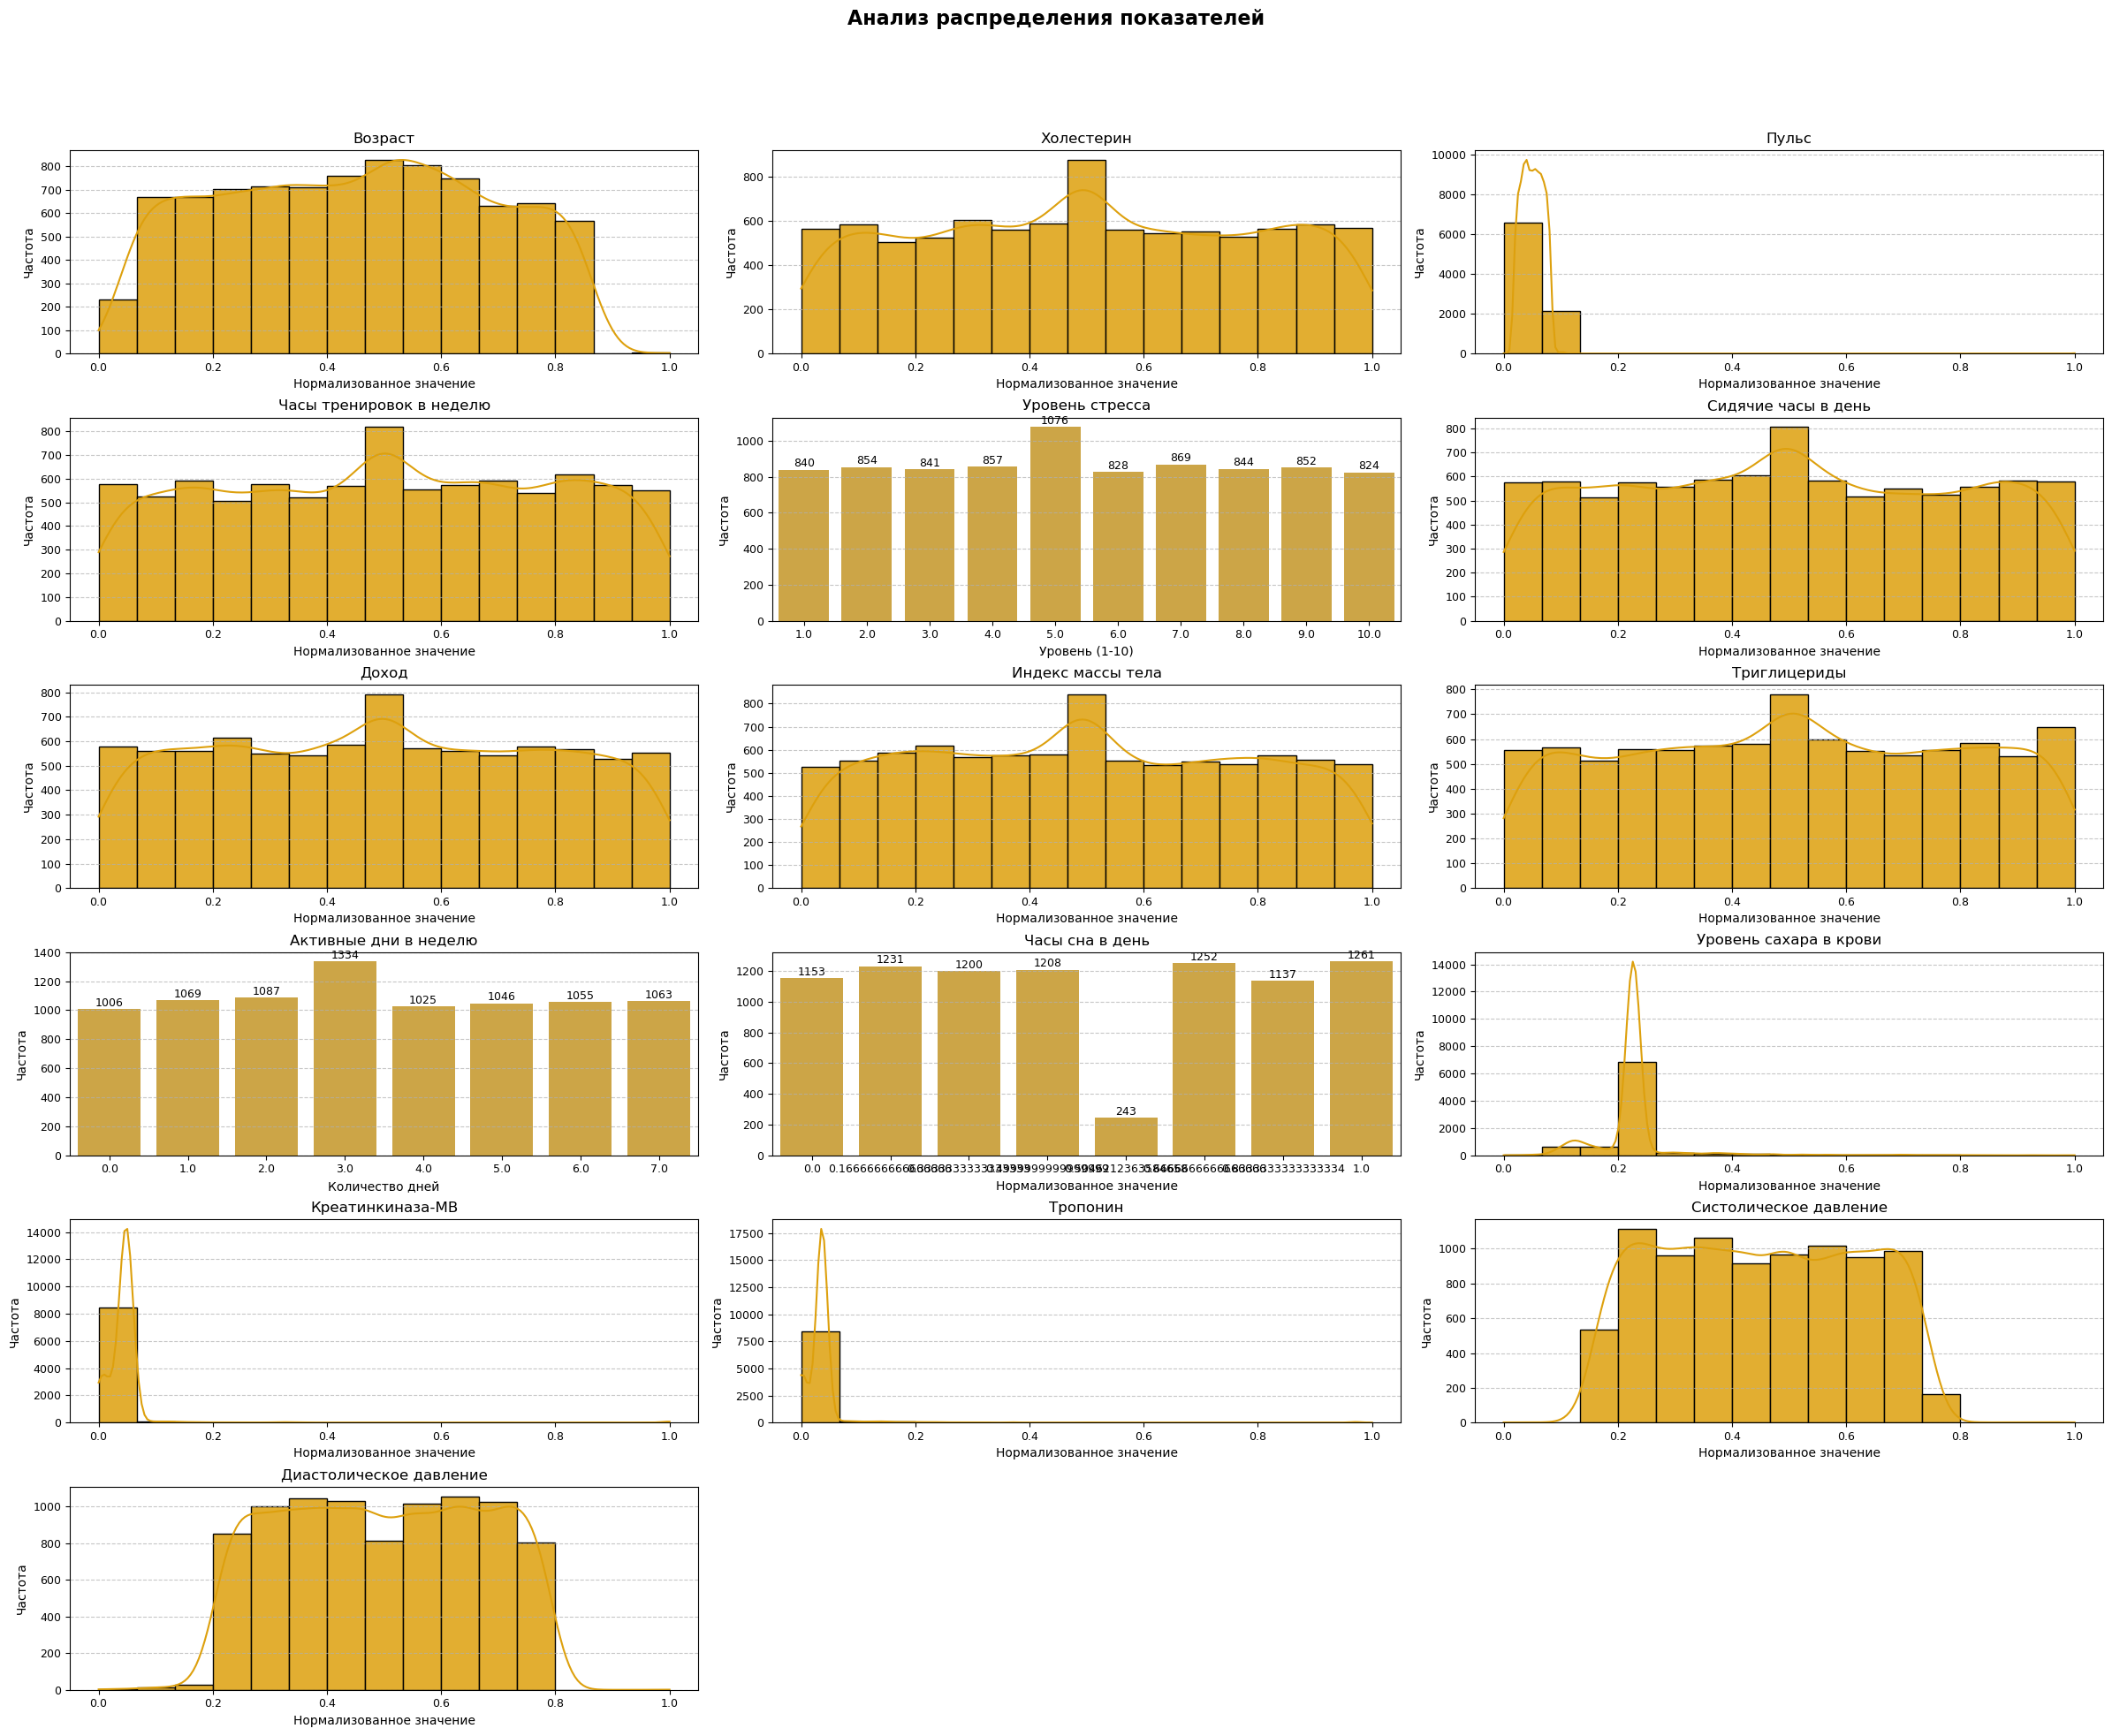


Интерпретация распределений:

• Возраст:
  - Среднее: 0.45
  - Медиана: 0.46
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.23

• Холестерин:
  - Среднее: 0.50
  - Медиана: 0.50
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.28

• Пульс:
  - Среднее: 0.05
  - Медиана: 0.05
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.02

• Часы тренировок в неделю:
  - Среднее: 0.50
  - Медиана: 0.50
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.28

• Уровень стресса:
  - Среднее: 5.48
  - Медиана: 5.00
  - Диапазон: от 1.00 до 10.00
  - Стандартное отклонение: 2.83

• Сидячие часы в день:
  - Среднее: 0.50
  - Медиана: 0.50
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.29

• Доход:
  - Среднее: 0.50
  - Медиана: 0.49
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.28

• Индекс массы тела:
  - Среднее: 0.50
  - Медиана: 0.49
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.28

• Триглицериды:
  - Среднее: 0.51


In [34]:
# строим графики для непрерывных признаков `heart_train`
plot_enhanced(heart_train, continuous_cols, labels)

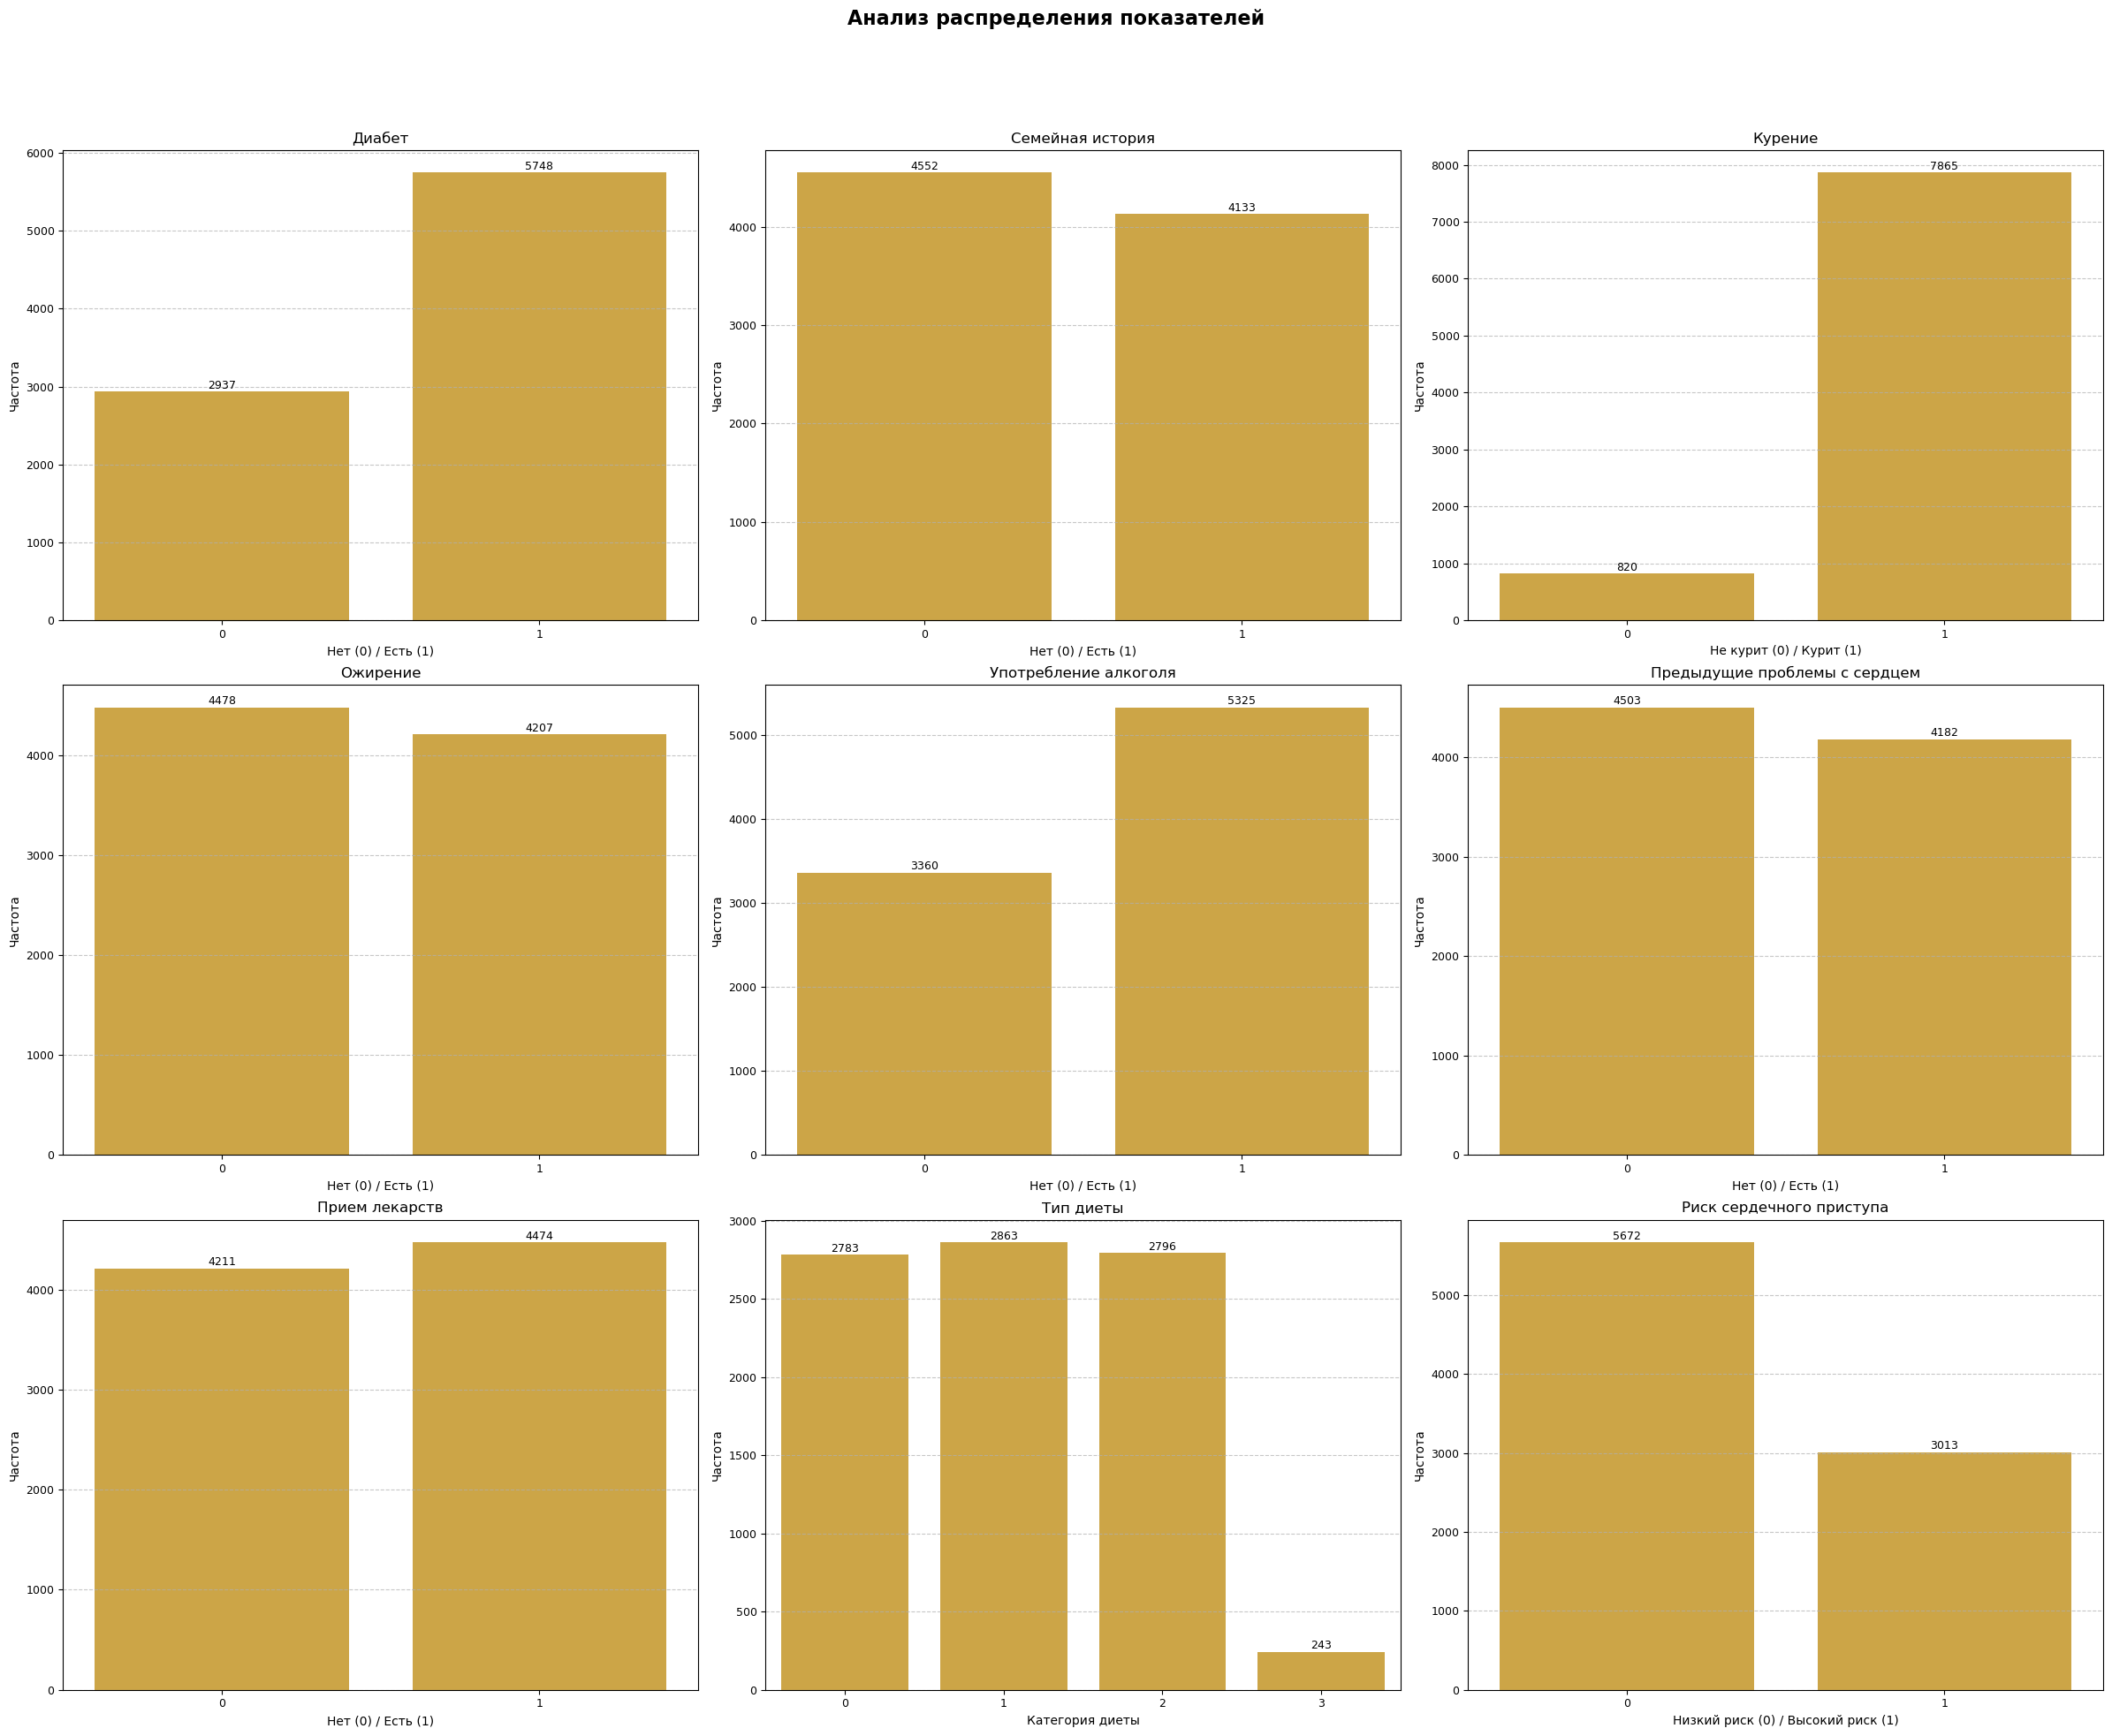


Интерпретация распределений:

• Диабет:
  - Среднее: 0.66
  - Медиана: 1.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.47

• Семейная история:
  - Среднее: 0.48
  - Медиана: 0.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.50

• Курение:
  - Среднее: 0.91
  - Медиана: 1.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.29

• Ожирение:
  - Среднее: 0.48
  - Медиана: 0.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.50

• Употребление алкоголя:
  - Среднее: 0.61
  - Медиана: 1.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.49

• Предыдущие проблемы с сердцем:
  - Среднее: 0.48
  - Медиана: 0.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.50

• Прием лекарств:
  - Среднее: 0.52
  - Медиана: 1.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.50

• Тип диеты:
  - Среднее: 1.06
  - Медиана: 1.00
  - Диапазон: от 0.00 до 3.00
  - Стандартное отклонение: 0.87

• Риск сердечного приступа:

In [35]:
# строим графики для дискретных признаков `heart_train`
plot_enhanced(heart_train, discrete_cols_train, labels)

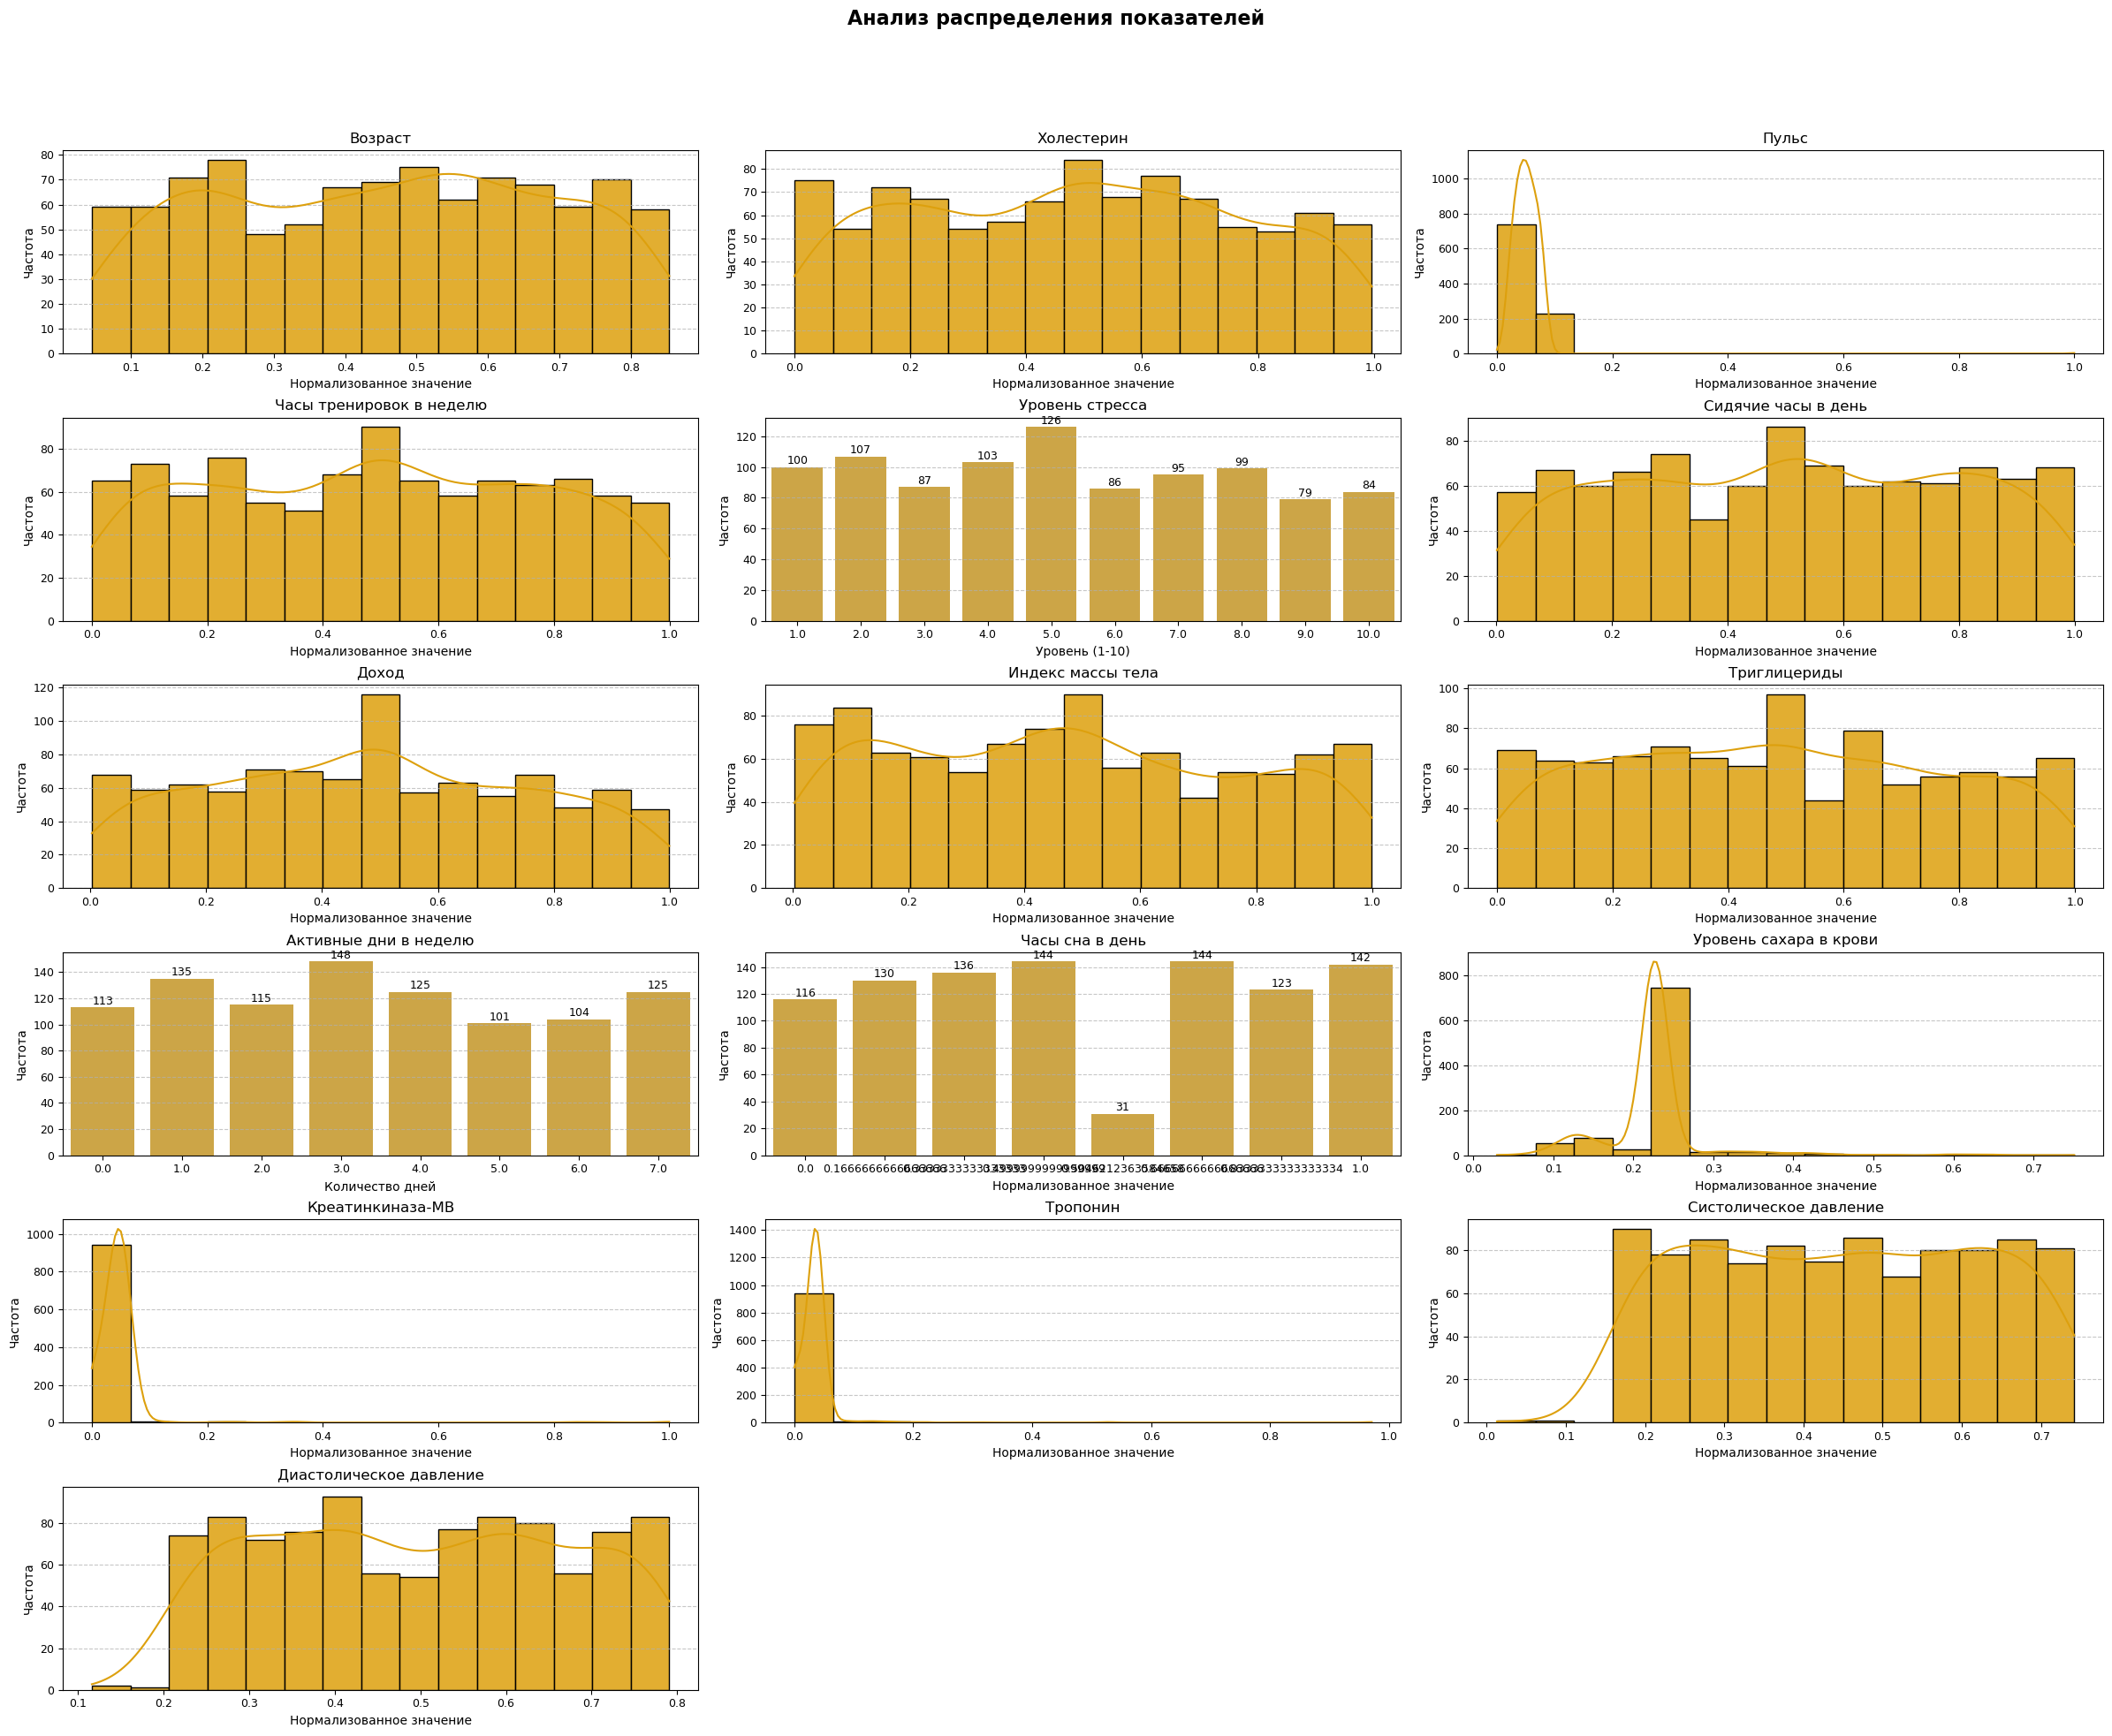


Интерпретация распределений:

• Возраст:
  - Среднее: 0.45
  - Медиана: 0.46
  - Диапазон: от 0.04 до 0.85
  - Стандартное отклонение: 0.23

• Холестерин:
  - Среднее: 0.49
  - Медиана: 0.50
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.28

• Пульс:
  - Среднее: 0.05
  - Медиана: 0.05
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.04

• Часы тренировок в неделю:
  - Среднее: 0.49
  - Медиана: 0.50
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.28

• Уровень стресса:
  - Среднее: 5.32
  - Медиана: 5.00
  - Диапазон: от 1.00 до 10.00
  - Стандартное отклонение: 2.81

• Сидячие часы в день:
  - Среднее: 0.51
  - Медиана: 0.50
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.29

• Доход:
  - Среднее: 0.48
  - Медиана: 0.49
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.27

• Индекс массы тела:
  - Среднее: 0.48
  - Медиана: 0.47
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.29

• Триглицериды:
  - Среднее: 0.49


In [36]:
# строим графики для непрерывных признаков `heart_test`
plot_enhanced(heart_test, continuous_cols, labels)

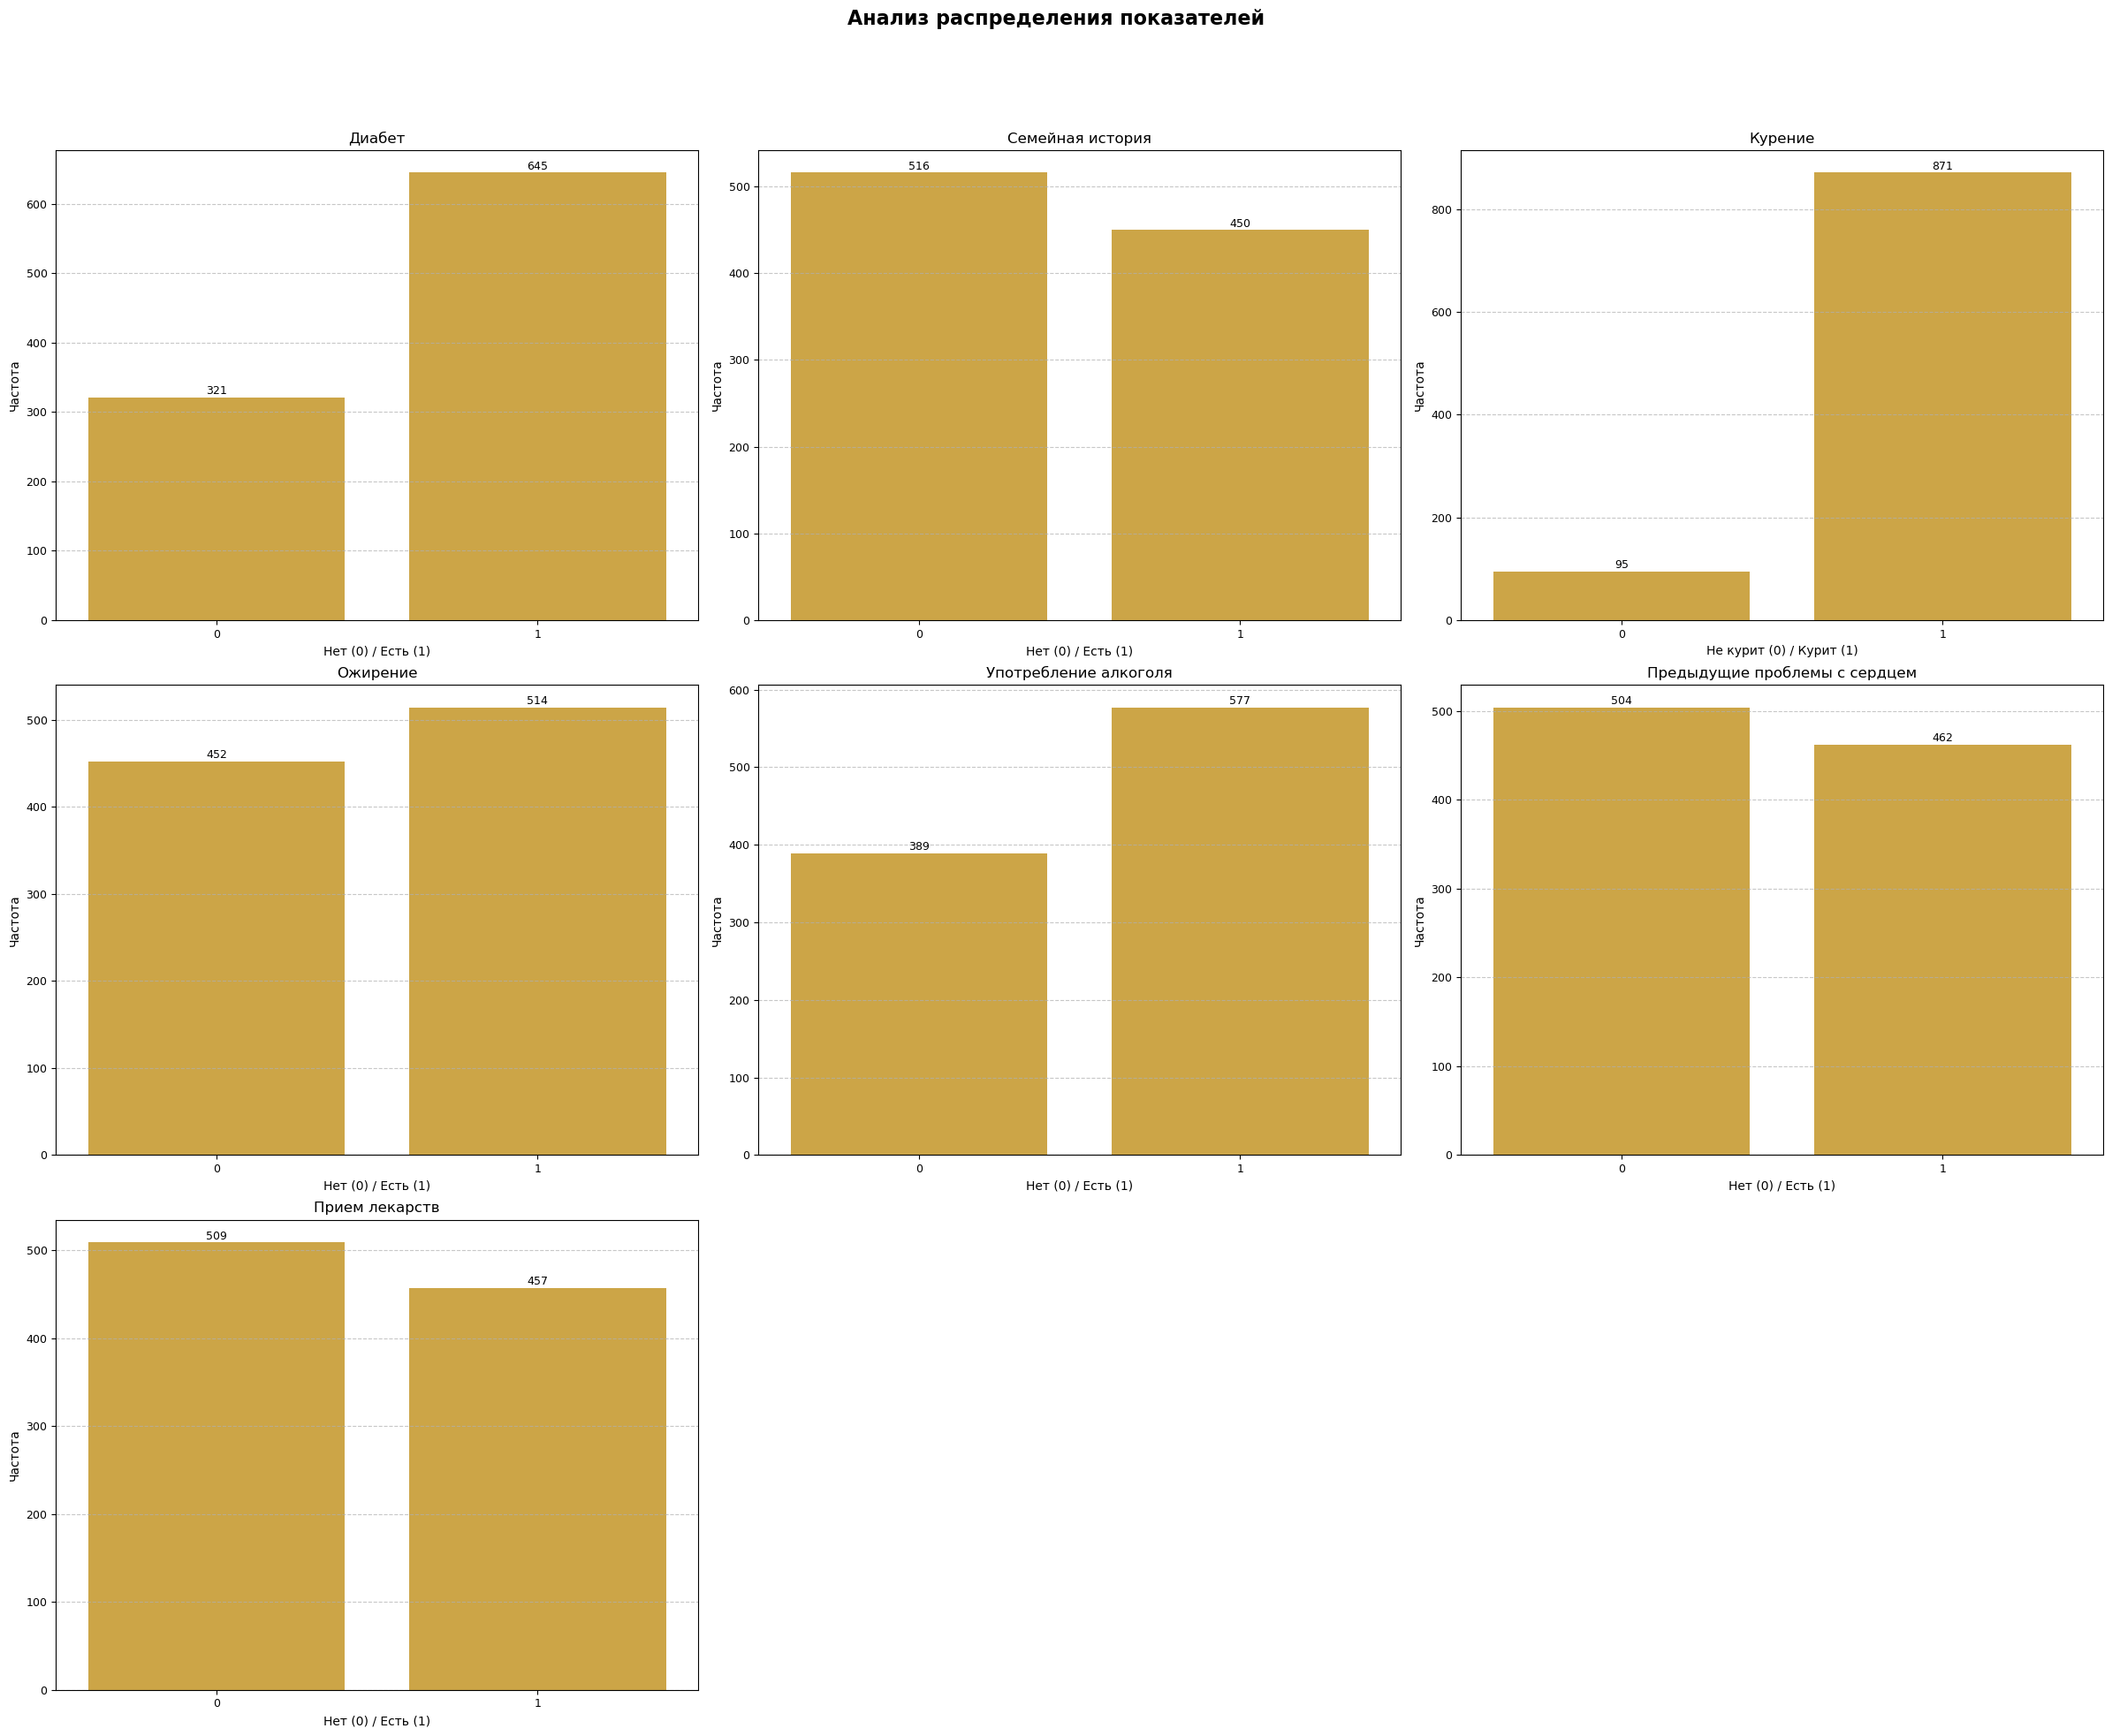


Интерпретация распределений:

• Диабет:
  - Среднее: 0.67
  - Медиана: 1.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.47

• Семейная история:
  - Среднее: 0.47
  - Медиана: 0.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.50

• Курение:
  - Среднее: 0.90
  - Медиана: 1.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.30

• Ожирение:
  - Среднее: 0.53
  - Медиана: 1.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.50

• Употребление алкоголя:
  - Среднее: 0.60
  - Медиана: 1.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.49

• Предыдущие проблемы с сердцем:
  - Среднее: 0.48
  - Медиана: 0.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.50

• Прием лекарств:
  - Среднее: 0.47
  - Медиана: 0.00
  - Диапазон: от 0.00 до 1.00
  - Стандартное отклонение: 0.50


In [37]:
# строим графики для дискретных признаков `heart_test`
plot_enhanced(heart_test, discrete_cols_test, labels)

**Вывод по распределению количественных показателей в данных**

**Положительные аспекты распределений:**

1. Согласованность train/test выборок:
* Возраст, холестерин, давление - практически идентичные распределения
* Демографические показатели (пол, доход) - хорошая сбалансированность
* Поведенческие факторы (курение, алкоголь, активность) - стабильные распределения

2. Качество нормализации:
* Большинство непрерывных признаков корректно нормализованы (0-1)
* Сохранены естественные формы распределений
* Минимальные смещения между выборками

3. Реалистичные медицинские показатели:
* Уровень стресса: средний уровень (5.3-5.5 из 10) - реалистично
* Физическая активность: 3.4-3.5 дней в неделю - правдоподобно
* Сон: нормальное распределение часов сна

**Выявленные проблемы:**

1. Целевая переменная: 34.7% случаев с риском сердечного приступа. Умеренный дисбаланс, это требует взвешивания классов.
2. Высокий уровень курения: 91% пациентов курят - нереалистично высокий показатель. Возможна смещенная выборка или ошибка в данных
3. Дисбаланс по диабету: 66-67% пациентов с диабетом - очень высокий процент, это может искажать влияние других факторов
4. Проблемы с биомаркерами: Blood sugar, CK-MB, Troponin - низкая вариативность, возможна недостаточная чувствительность измерений
5. Небольшие смещения:
* Ожирение: 48% (train) vs 53% (test) - разница 5%
* Принимающих лекарства: 52% (train) и 47% (test) - разница 5%.

**Стратегии обработки:**
* Для дисбаланса классов использовать F1-score, ROC-AUC, взвешивание классов
* Для низковариативных признаков проверить feature importance, возможно удалить
* Для смещенных признаков контролировать при кросс-валидации
* Стратифицированное разбиение для учета дисбаланса
* Использование bootstrap для оценки устойчивости модели

Общий вывод: качество данных в целом хорошее для построения прогнозной модели. Распределения большинства признаков реалистичны и согласованы между выборками. Модель должна показать хорошую обобщающую способность, так как распределения в train и test выборках достаточно схожи.

### Корреляционный анализ признаков.

Проведем корреляционный анализ признаков в количественной шкале. Рассчитаем `матрицу корреляций phik` для признаков тренировочной и тестовой выборок:

In [38]:
numeric_features_train = heart_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features_test = heart_test.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [39]:
def plot_phik_matrices(dt, interval_cols, name):

    corr_matrix = dt.phik_matrix(interval_cols=interval_cols)

    # визуализация матрицы корреляций
    plt.figure(figsize=(28, 25))
    sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1, 
            vmax=1,
            annot_kws={"size": 17},
            linewidths=0.5)
    plt.title(name, fontsize=25, pad=20, fontweight='bold')
    plt.xticks(rotation=30, ha='right', fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.show()

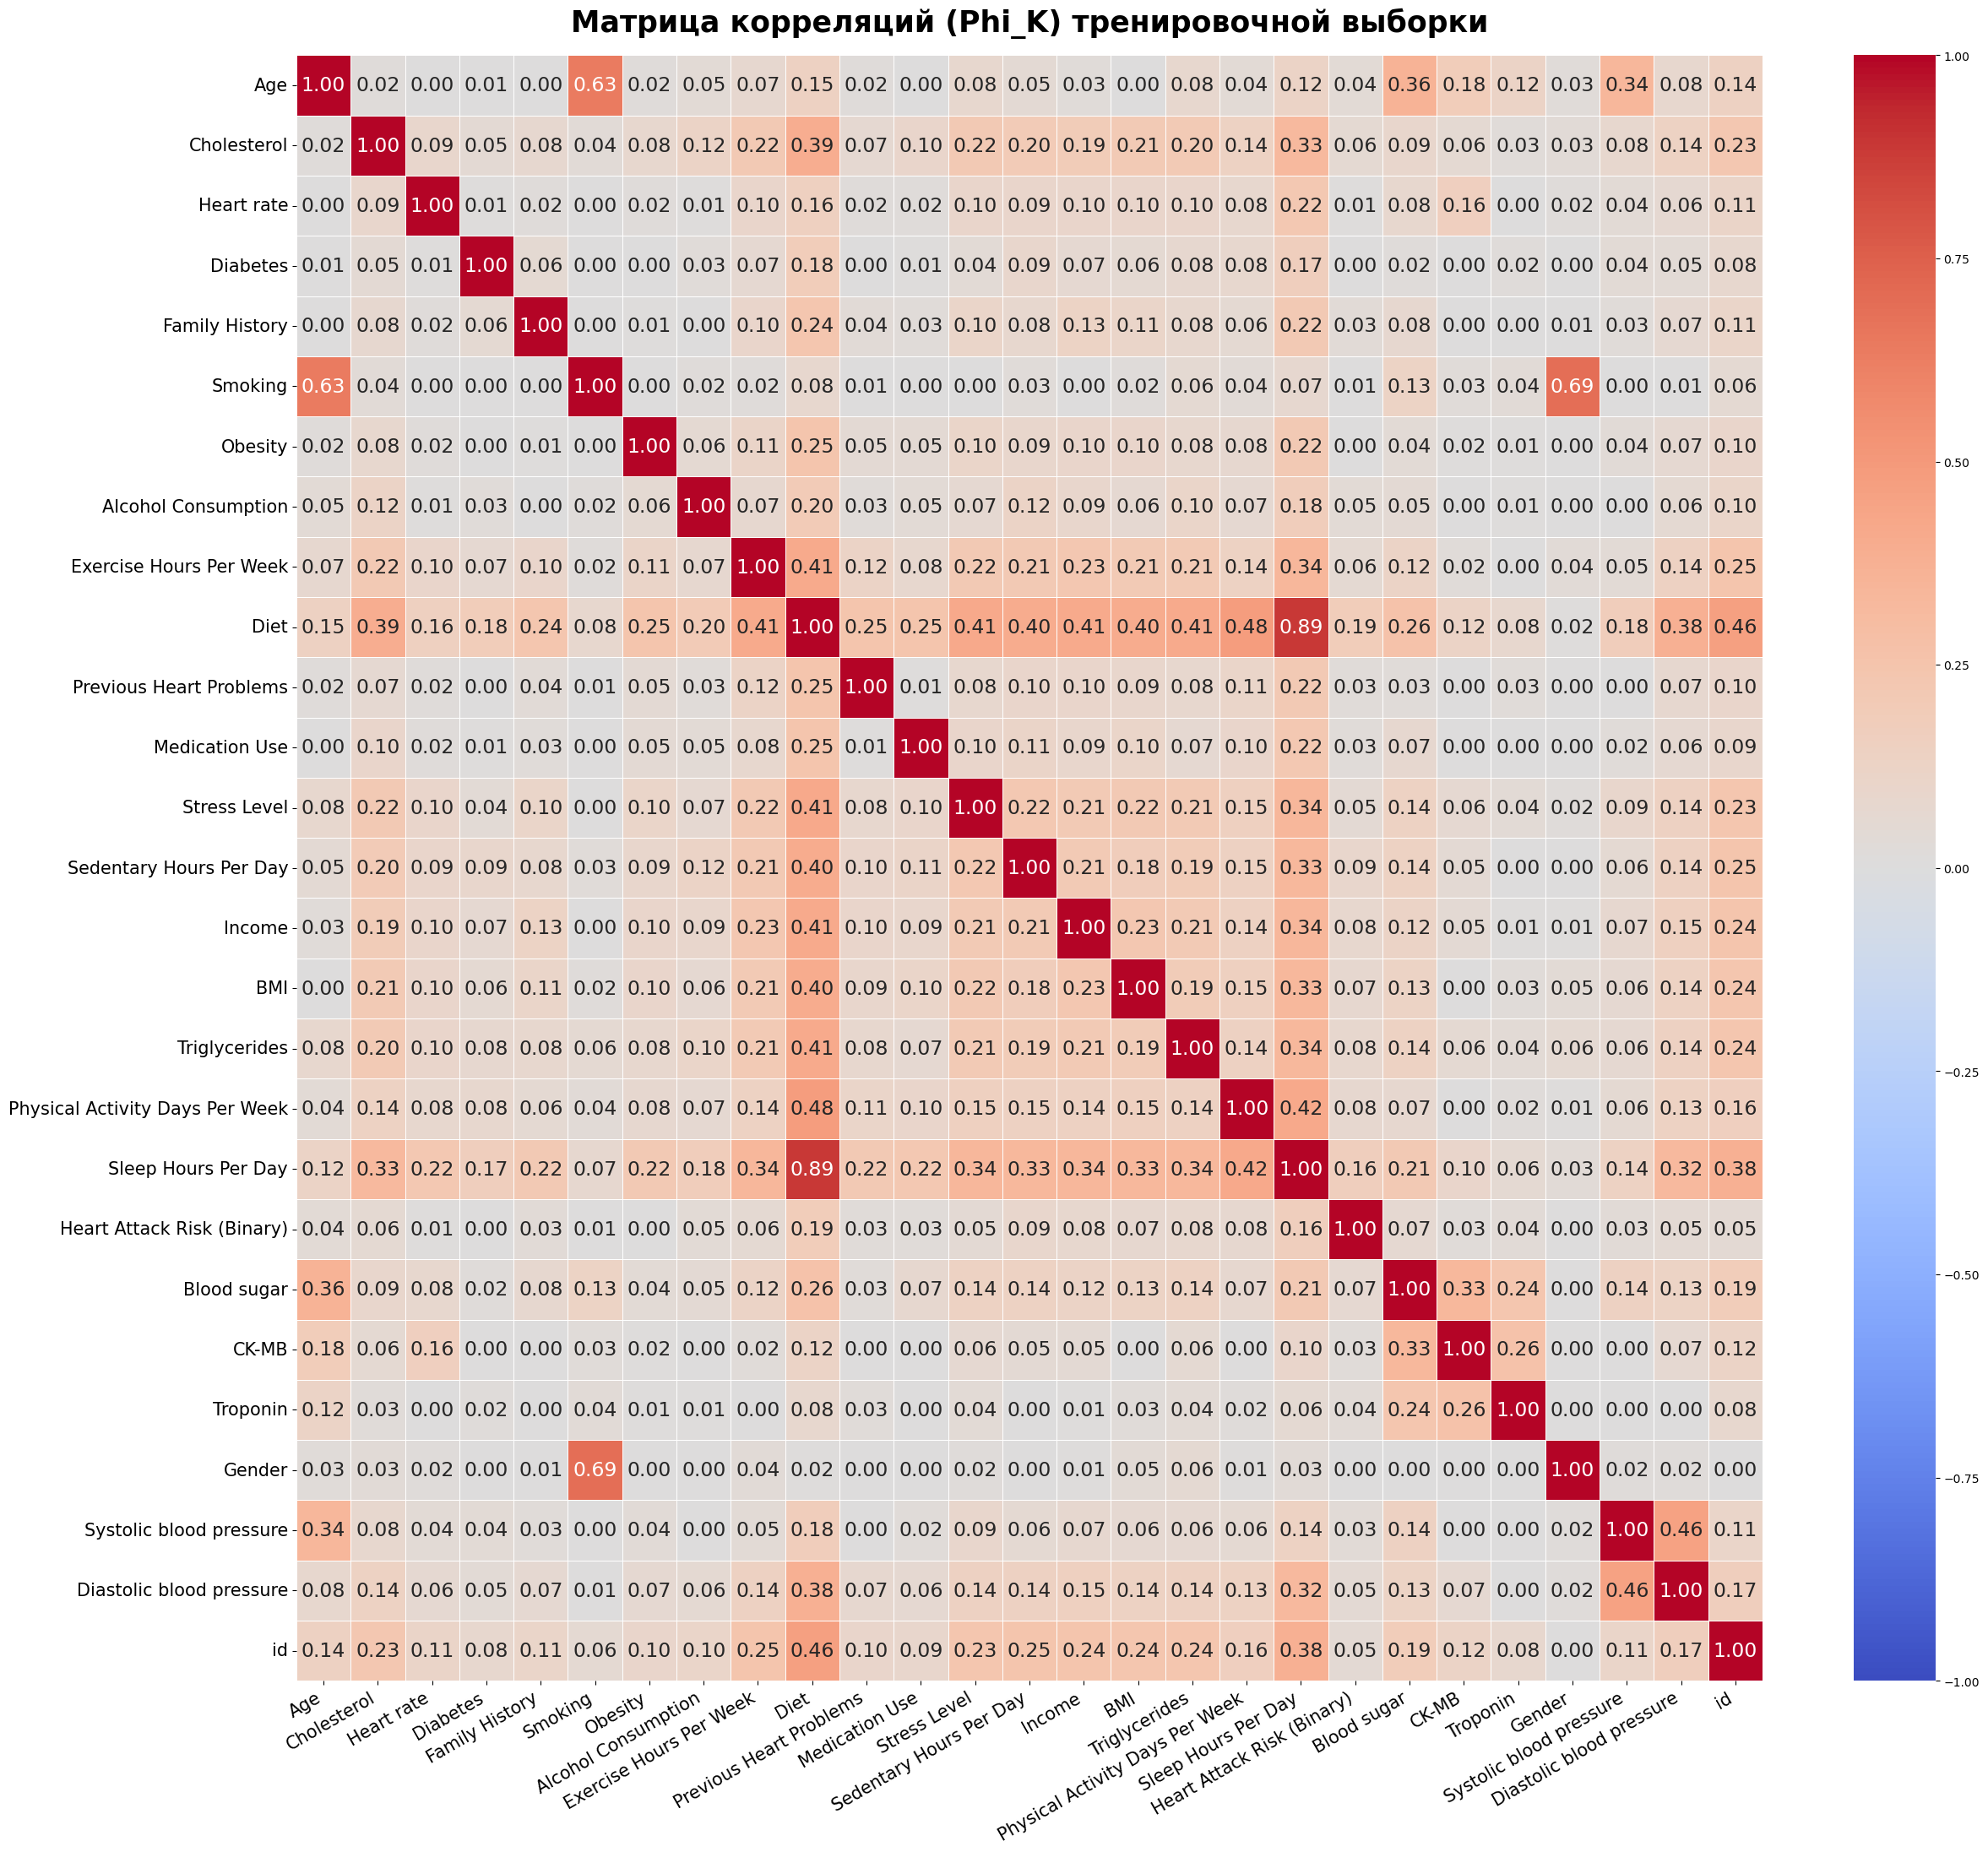

In [40]:
# корр. матрица для трен. выборки
plot_phik_matrices(heart_train, numeric_features_train, 'Матрица корреляций (Phi_K) тренировочной выборки')

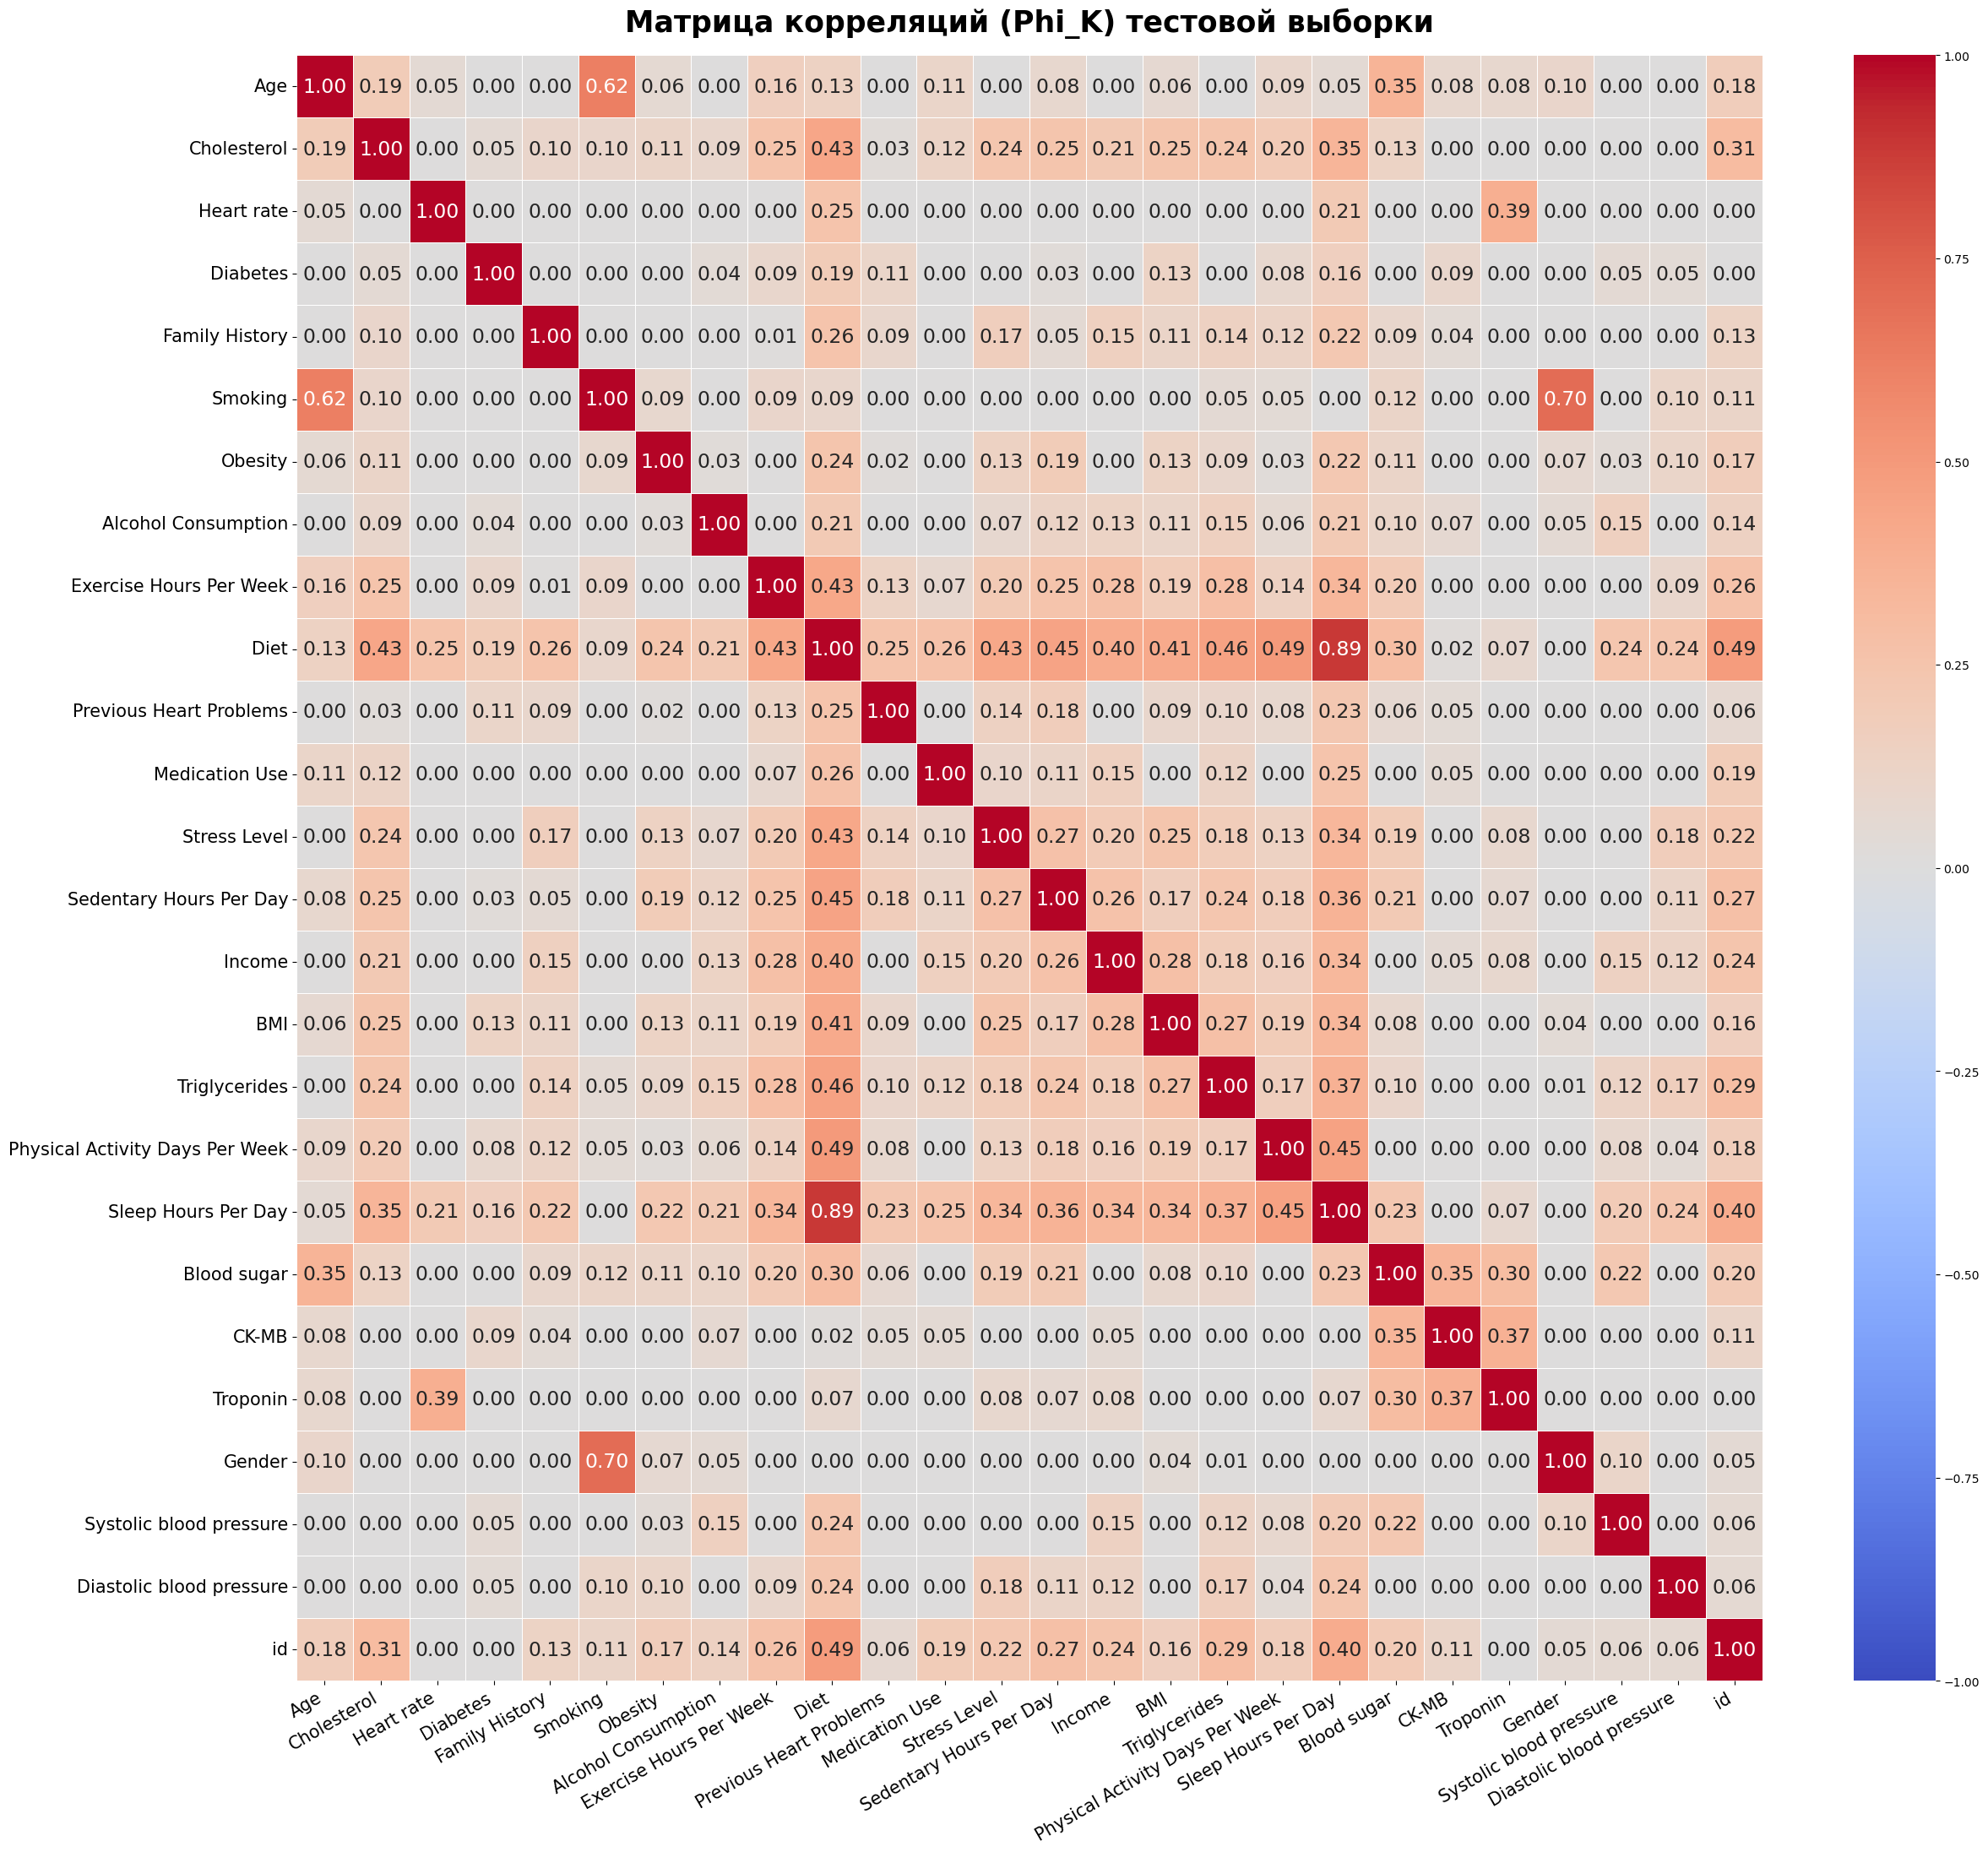

In [41]:
# корр. матрица для тестовой выборки
plot_phik_matrices(heart_test, numeric_features_test, 'Матрица корреляций (Phi_K) тестовой выборки')

**Сравнение матриц корреляции тренировочных и тестовых данных:**

**В тренировочной выборке:**

* Сильные связи:
  - `Diet` и `Sleeping hours her day ` - 0.89, сильнейшая связь.
  - `Gender` и `Smoking`: 0.7 - сильная связь
* Средние связи:
  - связь `Age` и `Smoking`: 0.62 - это умеренно-сильная связь, но не чрезвычайно  (все же меньше 0.7).
  - связь `CK-BM` и `Troponin`: 0.28 - это несильная связь, но важная саязь, что в принципе логично так как оба показателя являются прямыми маркерами сердечного приступа.
  - связь `CK-BM` и `Blood Sugar`: 0.34 - слабая умеренная связь.
  - связь `Blood sugar` с `Age`: 0.36 - слабая умеренная связь.
  - связь `Blood sugar` с `Heart rate`: 0.36 - слабая умеренная связь.
  
* связи с целевой переменной `Heart Attack Risk (Binary)`: все связи с целевой переменной были слабыми (меньше 0.1).
  
**В тестовой выборке**:

* Сильные связи:
*  - `Diet` и `Sleeping hours her day ` - 0.89, сильнейшая связь.
   - `Gender` и `Smoking`: 0.71 (в тренировочной 0.70).
* Средние связи:
  - связь `Age` и `Smoking`: 0.62 - это умеренно-сильная связь, но не чрезвычайно  (в тренировочной идентично 0.62).
  - связь `CK-BM` и `Troponin`: 0.52 - это достаточно сильная связь,  что в принципе логично так как оба показателя являются прямыми маркерами сердечного приступа (в тренировочной 0.28)
  - связь `CK-BM` и `Blood Sugar`: 0.38 - умеренная связь (в тренировочной 0.34)
  - связь `Blood sugar` с `Age`: 0.33 - слабая умеренная связь (в тренировочной 0.36)
  - связь `Blood sugar` с `Heart rate` (0.26) - слабая связь (в тренировочной 0.36).
  


**Выводы:**

* Устойчивые сильные связи (одинаковые в обеих выборках):
  - `Diet` и `Sleeping hours her day ` - 0.89, сильнейшая связь.
  - `Gender` и `Smoking` около 0.7 в обеих выборках.
  - `Age` и `Smoking` 0.62 в обеих выборках.

* Устойчивые средние связи:
  - `CK-BM` и `Troponin`: 0.52  (в тренировочной 0.28)
  - `CK-BM` и `Blood Sugar`: 0.38 (в тренировочной 0.34)
  - связь `Blood sugar` с `Age`: 0.33  (в тренировочной 0.36)
  - связь `Blood sugar` с `Heart rate`: 0.26  (в тренировочной 0.36).


Рекомендации:
* Рассчитать VIF показатели по признакам в обеих выборках. 

Рассчитываем VIF по признакам в тернировочной выборке:

In [42]:
# добавим константу в датафрейм heart_train, чтобы не искажались значения VIF
df_with_const = add_constant(heart_train)
# выберем только числовые признаки
num_features = df_with_const.select_dtypes(include=['number']).columns
# рассчитаем VIF для каждого признака
vif_corr(df_with_const, num_features)

,feature,VIF
0,const,79.557534
6,Smoking,1.633921
24,Gender,1.381643
1,Age,1.244730
10,Diet,1.037087
27,id,1.027123
11,Previous Heart Problems,1.012316
7,Obesity,1.010638
8,Alcohol Consumption,1.010561
5,Family History,1.010561


**Общая оценка мультиколлинеарности:**

Мультиколлинеарность в данных практически отсутствует. Все признаки имеют `VIF` в диапазоне 1.001-1.661, что значительно ниже порогового значения 5, это значит, что:
* все признаки безопасны для использования моделирования. Однако, признаки с утечкой следует исключить, несмотря на их низкий `VIF`
* можно использовать линейные модели (например, логистическая регрессия) без риска нестабильности
* не потребуется регуляризация для борьбы с мультиколлинеарностью

Рекомендации:
* Исключить признаки с утечкой данных
* Построить базовую модель `dummy model` со всеми оставшимися признаками
* Использовать feature importance для дальнейшего отбора
* Рассмотреть взаимодействия между Smoking и другими признаками

**Вывод о данных в исследовательском анализe**.

На основе комплексного анализа количественных и категориальных признаков в тренировочной и тестовой выборках можно сделать следующие ключевые выводы:

Данные демонстрируют высокое качество и хорошую согласованность между выборками. Основные вызовы связаны с потенциальной утечкой данных в некоторых признаках и дисбалансом классов. Рекомендуется исключить проблемные признаки, использовать методы борьбы с дисбалансом и сфокусироваться на интерпретируемых моделях.

Данные готовы для перехода к этапу построения прогнозных моделей с учетом выявленных особенностей и рекомендаций.

## Создание пайплайна для подготовки данных.

Так как мы ранее установили, что признаки `Troponin` и `CK-MB` являются прямыми медицинскими предикторами сердичного приступа, исключим эти признаки с утечкой до построения моделей. Также исключим признак 'Income', так как он экономический, а не медицинский и вляиния на сердечный приступ не несет. 

In [43]:
# признаки для исключения ДО построения моделей
leakage_features = ['Troponin', 'CK-MB']
technical_features = ['Income']

In [44]:
# разбиваем данные на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    heart_train.drop(['Heart Attack Risk (Binary)'] + leakage_features + technical_features, axis=1),
    heart_train['Heart Attack Risk (Binary)'],
    random_state = RANDOM_STATE,
    stratify = heart_train['Heart Attack Risk (Binary)']
)
# тестовая выборка
X_test = heart_test.drop(leakage_features + technical_features, axis=1)

In [45]:
# проведем тест Шапиро-Уилка на нормальность распределения целевого признака в трен.выборке
stat, p_value = st.shapiro(y_train)
display(f"Тест Шапиро-Уилка: statistic={stat}, p-value={p_value}")

# результаты
alpha = 0.05
if p_value > alpha:
    print("Нет оснований отвергнуть H0: данные распределены нормально")
else:
    print("Отвергаем H0: данные не распределены нормально")

'Тест Шапиро-Уилка: statistic=0.6015906849727413, p-value=1.4563778241191213e-81'

Отвергаем H0: данные не распределены нормально


**Результаты теста Шапиро-Уилка.**

1. Нулевая гипотеза:  
Данные происходят из нормального распределения.

2. Альтернативная гипотеза:
Данные не распределены нормально.

2. Значение p-value:
P-value = 1.2163257693246975e-87' < 0.05: отвергаем нулевую гипотезу , то есть данные не распределены нормально. А значит, целевая переменная `Heart Attack Risk (Binary)` имеет статистически значимое отклонение от нормального распределения.

**Выводы:**
* модель линейной регрессии может работать неоптимально, так как она предполагает нормальность распределения ошибок

Рекомендации: 
* использовать методы, более устойчивые к ненормальности, например, деревья решений. 
* использовать метрики ошибки более приспособленные к ненормальным распределениям, например, MAE (вместо MSE), ROC-AUC, F1-score или можно создать свою собственную метрику.

In [46]:
# оцениваем процент объектов каждого класса целевого признака 
y_train.value_counts(normalize=True)

Heart Attack Risk (Binary)
0    0.653155
1    0.346845
Name: proportion, dtype: float64

Уравновешивать доли целевого признака не будем, так как для оценки качества работы модели планируется использовать метрику  AUC-ROC, которая не нечувствительна к дисбалансу. 

`Кодирование и масштабирование`: не используем кодирование, так как данные нормализованы,  и имеется всего один  категориальный признак 'Diet' (0, 1, 2, 3), но он уже закодирован числами, поэтому OrdinalEncoder не нужен.

In [47]:
# признаки для OneHotEncoder (номинальные признаки)
ohe_columns = ['Diet', 'Gender'] 

# признаки для OrdinalEncoder отсутсвуют (порядковые признаки отсутсвуют)

# признаки для масштабирования
num_columns = ['Stress Level', 
               'Physical Activity Days Per Week']

# использование `LabelEncoder` для кодирования целевого признака - риска избыточно

Собираем пайплайн, обрабатывая также выше упомянутые пропуски с заполнением средним значением:

In [48]:
# SimpleImputer + OHE 
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        )
    ]
)
# для числовых признаков SimpleImputer + StandardScaler
num_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', MinMaxScaler())
    ]
)

In [49]:
# объединение всех шагов подготовки через ColumnTransformer
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='drop'
)

**Вывод по этапу "Создание пайплайна для подготовки данных".**

На данном этапе:
* были обозначены тренировочные данные и тестовые, первые были разделены на входные и целевой признаки
* был проведен тест Шапиро-Уилка на нормальность распределения целевого признака, тест подтвердил не нормальность распределения
* подготовлены данные для пайплайнов
* собраны пайплайны и трансформер

## Обучение моделей и подбор гиперпараметров.

### Поиск лучшей модели с помощью GridSearchCV.

Обучим четыре модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()`,  `SVC()` и анасамбли подберем гиперпараметры:  комбинацию модели и гиперпараметров - в словарь `param_grid`.

Для автоматического подбора модели и гиперпараметров будем использовать один общий пайплайн и инструмент `GridSearchCV()`, так как данный инструмент эффективен, так как сокращает количество проверок и охватывает достаточное количество комбинаций гиперпараметров за сравнительно короткое время. 



In [50]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
    ('preprocessor', data_preprocessor), 
    ('model', None)
    ]
)

Используем четыре модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и  `SVC()` и подберем гиперпараметры: комбинацию модели и гиперпараметров - в словарь `param_grid`.

In [51]:
# зададим гиперпараметры для моделей
param_grid = [
    # для KNeighborsClassifier
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(1, 20),
        'model__metric': ['cityblock', 'euclidean'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    # для SVC
    {
        'model': [SVC(random_state=RANDOM_STATE, probability=True)],
        'model__C': [1, 2, 20],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    # для LogisticRegression
    {
        'model': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'model__C': range(1, 6),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    # для DecisionTreeClassifier
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(1, 11),
        'model__min_samples_split': range(2, 6),
        'model__min_samples_leaf': range(1, 6)
    },
    # для RandomForestClassifier
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2', None]
    },
    # для GradientBoostingClassifier
    {
        'model': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    # для XGBoost 
    {
        'model': [XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')],
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }
]

In [52]:
scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1_weighted': 'f1_weighted',
    'roc_auc': 'roc_auc',
    'accuracy' : 'accuracy'
}

# перебор гиперпараметров методом GridSearchCV
grid_search = GridSearchCV(pipe_final, 
                           param_grid, 
                           cv=5, 
                           refit='f1_weighted',
                           scoring=scoring, 
                           n_jobs=-1
                          )

In [53]:
# запускаем подбор гиперпараметров на тренировочных данных 
grid_search.fit(X_train, y_train)

,estimator,"Pipeline(step...odel', None)])"
,param_grid,"[{'model': [KNeighborsClassifier()], 'model__metric': ['cityblock', 'euclidean'], 'model__n_neighbors': range(1, 20), 'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]}, {'model': [SVC(probabili...ndom_state=42)], 'model__C': [1, 2, ...], 'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]}, ...]"
,scoring,"{'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted', 'precision': 'precision', 'recall': 'recall', ...}"
,n_jobs,-1
,refit,'f1_weighted'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ohe', ...), ('num', ...)]"


In [54]:
display(f'Метрика F1-мера(учитывает дисбаланс классов) при кросс-валидации: {grid_search.best_score_:.3f}')

'Метрика F1-мера(учитывает дисбаланс классов) при кросс-валидации: 0.575'

In [55]:
# cоздаём датафрейм с результатами работы GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)

print('Метрики лучшей модели:')
for score in scoring.keys():
    print(f'{score}:', end='')
    print(round(results.iloc[grid_search.best_index_, :][f'mean_test_{score}'], 3))

Метрики лучшей модели:
recall:0.21
precision:0.39
f1_weighted:0.575
roc_auc:0.544
accuracy:0.612


Метрики recall, precision, и поэтому и f1, довольно низкие. Accuracy = 0.612, то есть модель близка к прогнозным свойствам к случайному выбору. Сравним с Дамми моделью по f1 метрике:

In [56]:
# дамми-модель для базового сравнения
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_scores = cross_val_score(dummy, X_train, y_train, cv=5, scoring='f1_weighted')

print(f"Dummy model: {np.mean(dummy_scores):.4f}")

Dummy model: 0.5161


Отранжируем результаты кросс-валидации лучших моделей:

In [57]:
# получаем результаты и сортируем по accuracy
rank_score_ml = pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_accuracy', ascending=False)

# извлекаем имя модели из параметров
rank_score_ml['model_name'] = rank_score_ml['params'].apply(
    lambda x: x['model'].__class__.__name__)

# создаем сводную таблицу с моделями
pivot = rank_score_ml.pivot_table(
    index='model_name',
    values=['mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy'],
    aggfunc='first').sort_values('rank_test_accuracy')

display(pivot)

,mean_test_accuracy,rank_test_accuracy,std_test_accuracy
model_name,,,
XGBClassifier,0.654535,1,0.011480
SVC,0.654074,4,0.009720
GradientBoostingClassifier,0.653307,7,0.010759
DecisionTreeClassifier,0.653153,18,0.010587
LogisticRegression,0.653153,18,0.010587
KNeighborsClassifier,0.642712,334,0.008108
RandomForestClassifier,0.640412,354,0.013334


**Вывод по лучшей модели и гиперпараметрам.**

Лучшей себя показала модель `KNeighborsClassifier` (метрики при кросс-валидации: f1=0.58, accuracy=0.62) с параметрами n_neighbors=	9, metric = "cityblock").
Модель близка к прогнозным свойствам к случайному выбору, однако все же выигрывает у Дамми модели (F1 мера Dummy model: 0.51).

### Оценка важности признаков для лучшей модели и график важности.

Построим график важности признаков для лучшей модели:

Перестановочная важность признаков:
                            feature  importance       std
12                     Stress Level    0.051986  0.003459
16  Physical Activity Days Per Week    0.050051  0.004051
9                              Diet    0.046624  0.005397
19                           Gender    0.034288  0.002993
0                               Age    0.000000  0.000000
21         Diastolic blood pressure    0.000000  0.000000
20          Systolic blood pressure    0.000000  0.000000
18                      Blood sugar    0.000000  0.000000
17              Sleep Hours Per Day    0.000000  0.000000
15                    Triglycerides    0.000000  0.000000
14                              BMI    0.000000  0.000000
13          Sedentary Hours Per Day    0.000000  0.000000
11                   Medication Use    0.000000  0.000000
1                       Cholesterol    0.000000  0.000000
10          Previous Heart Problems    0.000000  0.000000
8           Exercise Hours Per Week 

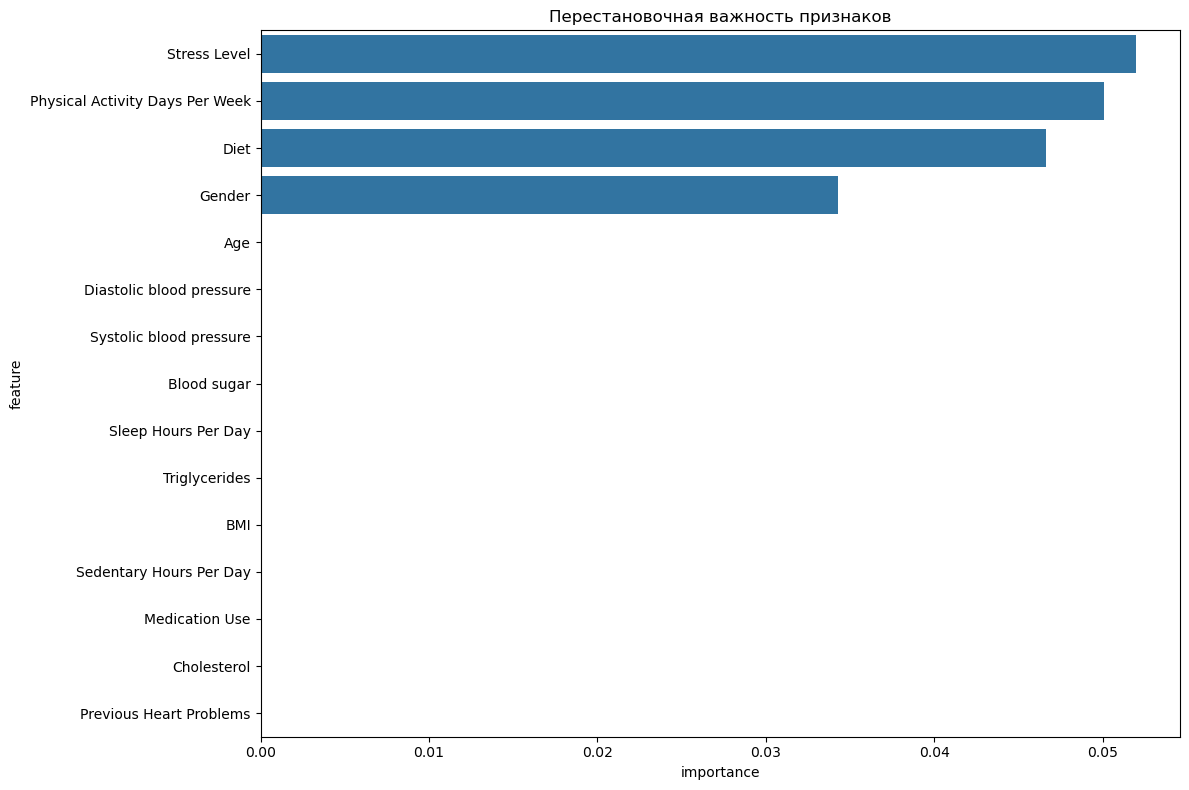

In [58]:
best_model = grid_search.best_estimator_
# вычисляем перестановочную важность
perm_importance = permutation_importance(
    best_model, 
    X_train, 
    y_train, 
    scoring='f1_weighted',
    n_repeats=10,
    random_state=RANDOM_STATE
)

# создаем DataFrame
perm_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

print("Перестановочная важность признаков:")
print(perm_df)

# Визуализация
plt.figure(figsize=(12, 8))
sns.barplot(data=perm_df.head(15), x='importance', y='feature')
plt.title('Перестановочная важность признаков')
plt.tight_layout()
plt.show()

**Анализ важности признаков для лучшей модели**

Наиболее важные признаки: 
* `Stress Level` (0.051986) уровень стресса - самый важный фактор. Показывает связь между уровнем стресса и риском сердечного приступа.
* `Physical Activity Days Per Week` (0.050051)количество Физически активных дней в неделю - второй по важности фактор при прогнозировании риска сердечного приступа. Показывает, количество активных дней сильно влияет на вероятность риска сердечного приступа.
* `Diet` (0.046624) диета - третий по значимости фактор. Подтверждает, что при правильном питании риск сердечно-сосудистых заболеваний снижается. 
* `Gender` (0.034288) пол - четвертый по значимости фактор. Подтверждает медицинскую статистику, что мужской пол чаще страдает от сердечного приступа.
  
Остальные признаки не имеют (имеют минимальное) влияние на риск сердечного приступа. 

### Выбор лучшего порога.

Для предсказания риска сердечного приступа изменим порог, чтобы минимизировать ошибки II-го рода FN и соответсвенно максимизировать метрику `Recall`.

Построим кривую по метрикам `precision` и `recall`.

In [59]:
# получаем лучший пайплайн
best_pipe = grid_search.best_estimator_
# достаём из пайплайна модель
best_model = best_pipe.named_steps['model']
# достаём препроцессор
preprocessor = best_pipe.named_steps['preprocessor']

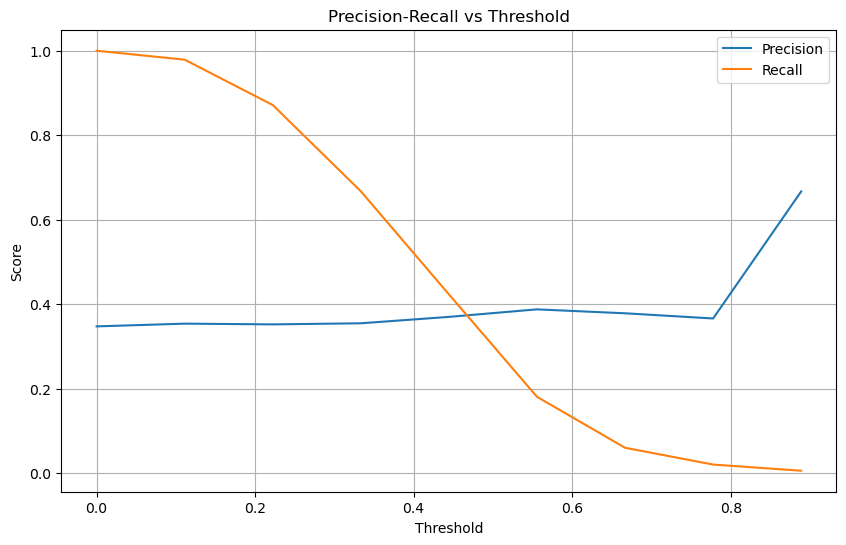

In [60]:
# преобразовываем X_val с помощью обученного препроцессора
X_val_transform = preprocessor.transform(X_val)

# предсказание на валидационных данных
y_val_proba = best_pipe.named_steps['model'].predict_proba(X_val_transform)[:, 1]

# строим кривую Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.grid(True)
plt.show()

Из графика precision-recall видно, что при увеличении порога recall падает, а precision растет. Найдём порог, при котором метрика recal близка к 1, а f1 будет максимальной:

In [61]:
thresholds = np.linspace(0, 1, 101)

# реалистичные целевые значения
search_recall = 0.9  # ищем 90% recall 
best_threshold = 0.5
best_f1_so_far = 0
results = []

for threshold in thresholds:
    y_pred_threshold = (y_val_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_threshold, labels=[0,1]).ravel()
    precision = precision_score(y_val, y_pred_threshold, zero_division=0)
    recall = recall_score(y_val, y_pred_threshold, zero_division=0)
    f1 = f1_score(y_val, y_pred_threshold, zero_division=0)
    
    results.append({
        'threshold': round(threshold, 3),
        'precision': round(precision, 3),
        'recall': round(recall, 3),
        'f1': round(f1, 3),
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    })
    
    # ищем порог с recall >= 0.9 и максимальным F1
    if recall >= search_recall and f1 > best_f1_so_far:
        best_f1_so_far = f1
        best_threshold = threshold

thresholds_df = pd.DataFrame(results)
best_row = thresholds_df.loc[thresholds_df['threshold'] == round(best_threshold, 3)]

print(f'Лучший порог = {best_threshold:.3f}')
print(f'При этом пороге:')
print(f'  Precision: {best_row["precision"].values[0]:.3f}')
print(f'  Recall: {best_row["recall"].values[0]:.3f}')
print(f'  F1-score: {best_row["f1"].values[0]:.3f}')

Лучший порог = 0.010
При этом пороге:
  Precision: 0.354
  Recall: 0.979
  F1-score: 0.520


Лучший порог равен 0.01:
* Очень низкий порог классификации - модель будет предсказывать класс "1" даже при очень низкой вероятности (всего 1%)
* Максимизация `Recall`, то есть мы почти не пропускаем настоящие положительные случаи (Recall 97.9%) рисков сердечных приступов - из 100 реальных случаев "1" модель находит 98.
* `Precision` - при этом много ложных срабатываний (`Precision` всего 35.4%), есть высока веротяность того, что здоровому человеку припишут риск сердечного приступа - из 100 предсказанных "1" только 35 действительно верные.

При пороге 0.01 - будет много "ложных тревог", но почти не будет пропущенных случаев.
Подходит для медицинской диагностики, где пропуск болезни опаснее ложной тревоги.

Построим матрицу ошибок.

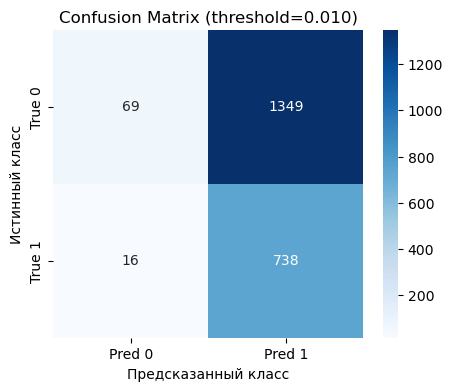

In [62]:
# матрица ошибок для лучшего порога
best_pred = (y_val_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_val, best_pred, labels=[0,1])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title(f'Confusion Matrix (threshold={best_threshold:.3f})')
plt.show()

**Вывод по матрице ошибок:**

* много `False Positives` (FP) ложных срабатываний - 1349. 
* мало `False Negatives` (FN)  пропущенных случаев - 69
* низкое количество `True Negatives` (TN)  правильно определенных отрицательных случаев - всего 16. То есть модель плохо определяет класс "0".

Однако с тем, мы почти не упускаем ни одного пациента с настоящим риском приступа, выходит, что это тот баланс, достигнутый при качестве переданным нам данных. 

### Рассчет прогноза на тестовых данных и сохранение результатов в CSV-файл


Рассчитаем вероятности предсказаний на тестовой выборке. Предсказания переведем в классы - 1 (есть риск) и 0 (нет риска) с помощью оптимального найденного порога.

In [63]:
# рассчет прогноза на тестовых данных
y_pred = grid_search.predict_proba(X_test)[:, 1]
# определяем классы 1 и 0
y_pred = (y_pred >= best_threshold).astype(float)

y_pred_1 = (y_pred == 1.0).sum()
y_pred_0 = (y_pred == 0.0).sum()
print(f'Количество предсказаний класса "1": {y_pred_1}')
print(f'Количество предсказаний класса "0": {y_pred_0}')

Количество предсказаний класса "1": 918
Количество предсказаний класса "0": 48


**Анализ распределения предсказаний:**

- Класс "1" (есть риск): 918 случаев (95%)
- Класс "0" (нет риска): 48 случаев (5%)

1. Высокая чувствительность модели. Она очень "осторожная" - в 95% случаев предсказывает риск. Это хорошо для медицинской задачи, где пропуск сердечного приступа опаснее ложной тревоги.

2. Мало случаев без риска - всего 5%. Много ложных срабатываний

3. Практические применение модели (плюсы и минусы):
* (+) почти не пропускает реальные случаи сердечного приступа
* (+) подходит для скрининга в группах высокого риска, то есть будет полезна для людей, у кого есть первичные попозрения на проблемы с сердцем. 
* (-) из-за ложных положительных срабатываний возможна паника пациентов и много ненужных дополнительных обследований (но возможно это плюс для небюджетного ЛПУ).

Сохраним `Предсказания` и `id` (по ТЗ) в CSV-файл `heart_predictions.csv`:

In [64]:
data_dir = Path("../data")
data_dir.mkdir(exist_ok=True)

predictions_df = pd.DataFrame({
    "id": range(len(y_pred)),          # в порядке строк heart_test
    "prediction": y_pred.astype(int)   # приводим к int
})

predictions_df.to_csv(data_dir / "heart_predictions.csv", index=False)

### Сохранение обученного найплайна и наилучшего порога.

Упакуем лучшую модель и препроцессинг в `joblib`, чтобы `FastAPI` мог это грузить.

Модель не должна зависеть от ненужных столбцов. Поэтому сервис должен отбрасывать всё лишнее автоматически, и для жтого мы сделали:
* в этом проекте определили, какие колонки лишние ("Unnamed: 0")
* сохраним списки `leakage_features` и `technical_features` в meta.json

Теперь сервис будет всегда использовать эти списки при подготовке данных (когда новые данные придут в FastAPI):
* "Unnamed: 0" просто будет выброшен автоматически
* модель возьмёт только нужные признаки


In [69]:
# берём лучший пайплайн из GridSearchCV
final_pipeline = grid_search.best_estimator_

# создаем артефакты для FastAPI
artifacts_dir = Path("../artifacts")
artifacts_dir.mkdir(exist_ok=True)

# сохраняем обученный пайплайн
joblib.dump(final_pipeline, artifacts_dir / "pipeline.joblib")

# сохраняем мета-информацию (порог + списки признаков, которые выкидывали)
meta = {
    "threshold": float(best_threshold),
    "leakage_features": leakage_features,
    "technical_features": technical_features
}
with open(artifacts_dir / "meta.json", "w") as f:
    json.dump(meta, f)

После этого шага в корне репо должны лежать:

* `data/heart_predictions.csv`
* `artifacts/pipeline.joblib`
* `artifacts/meta.json`

Данные в проекте подгтовлены для FastAPI: были выполнены EDA, обучение, выбор модели, выбор порога, сохранение предсказаний и артефактов.

## Общий вывод

**Описание задач:**
* Изучение данных открытого источника с медицинскими показателями и риском сердечных приступов.  
* Задача 1: построить модель, которая сможет предсказать риск сердечных приступов (где 0 - нет риска, 1 - есть риск). 
* Задача 2: создать приложение на FastAPI (или аналогичном фреймворке) которое принимает на вход путь к csv-файлу тестовой выборки, выполняет предсказание и возвращает предсказание -  риск сердечных приступов (ответ в формате JSON). 

**Этапы работы:**

Исходные данные и проведённая обработка данных:
* для исследовании использовались данные открытого источника с медицинскими показателями из нескольких таблиц: тренировочной и  тестовой выборки. 
* в ходе предобработки данных были проверены  и исправлены типы данных, дубликаты и пропущенные значения в датасетах для обоих датасетов.
* в ходе исследовательского анализа был проведен статистический анализ данных, построена матрица корреляции признаков.
 
Для поиска лучшей модели 1 и 2 задачи былы построены пайплайн, и с помощью чего были выбрана лучшие модели для числового неприрывного целевого признака, а также для категории. В ходе этапа создания пайплайнов была проведена следующая работа: 
* написаны пайплайны обработки данных 
* обучено пять моделей для и выбрана лучшая модель по метрикам
* для оценки качества модели была выбрана метрика `F1-мера`,  данный выбор был обоснован.

Наилучшей себя показала модель `KNeighborsClassifier` (метрики при кросс-валидации: f1=0.58, accuracy=0.62) с параметрами n_neighbors=	9, metric = "cityblock").
Модель близка к прогнозным свойствам к случайному выбору, однако все же выигрывает у Дамми модели (F1 мера Dummy model: 0.51).

Анализ важности признаков при посике лучшей модели:
* `Stress Level` (0.051986) уровень стресса - самый важный фактор. Показывает связь между уровнем стресса и риском сердечного приступа.
* `Physical Activity Days Per Week` (0.050051)количество Физически активных дней в неделю - второй по важности фактор при прогнозировании риска сердечного приступа. Показывает, количество активных дней сильно влияет на вероятность риска сердечного приступа.
* `Diet` (0.046624) диета - третий по значимости фактор. Подтверждает, что при правильном питании риск сердечно-сосудистых заболеваний снижается. 
* `Gender` (0.034288) пол - четвертый по значимости фактор. Подтверждает медицинскую статистику, что мужской пол чаще страдает от сердечного приступа.
  
Для предсказания риска сердечного приступа был найден лучший порог, чтобы минимизировать ошибки II-го рода FN и соответсвенно максимизировать метрику `Recall`. Лучший порог равен 0.01:
* Очень низкий порог классификации - модель будет предсказывать класс "1" даже при очень низкой вероятности (всего 1%)
* Максимизация `Recall`, то есть мы почти не пропускаем настоящие положительные случаи (Recall 97.9%) рисков сердечных приступов - из 100 реальных случаев "1" модель находит 98.
* `Precision` - при этом много ложных срабатываний (`Precision` всего 35.4%), есть высока веротяность того, что здоровому человеку припишут риск сердечного приступа - из 100 предсказанных "1" только 35 действительно верные.
  
Дополнительные наблюдения:
* При пороге 0.01 - будет много "ложных тревог", но почти не будет пропущенных случаев.
* Подходит для медицинской диагностики, где пропуск болезни опаснее ложной тревоги.




**Выводы и дополнительные предложения для бизнеса:**

* Снижение затрат на массовую диагностику за счет целевого скрининга
* Раннее выявление пациентов группы риска
* Автоматизация первичного осмотра
* Масштабируемость решения для различных медицинских учреждений

**Итог:**  даже если модель предсказаний далека от совершенсва по метрикам, испльзуя данный сервис можно сокаратить затраты в Здавоохранении, так как `затраты на ложное срабатывание` < `затраты на пропущенный случай`
* Ложное срабатывание: дополнительные обследования (около 15000 - 40000 руб.)
* Пропущенный случай: лечение осложнений + возможная инвалидность (от 400000 руюлей в год)